In [1]:
import numpy as np
from scipy import stats
from sklearn.metrics import r2_score,cohen_kappa_score,balanced_accuracy_score,\
    median_absolute_error,matthews_corrcoef
from collections import defaultdict

%load_ext sql
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
plt.rcParams['font.size'] = '16'
figdir = '/home/glandrum/Papers/OverlappingAssays/images/'


# The data gathering and analysis

In [2]:
def gather_data(standard_type,maxMatch=True,includeAssayType=True,
                minOverlap=5,minAssaySize=20,maxAssaySize=100,
                includeActivityCuration=True,onlyDocs=True,removeMutants=True,noDuplicateDocs=True,
                onlyHighConfidence=True):
    # password is stored in ~/.pgpass, so we don't need to worry about it here
    connection_string = f"postgresql://ccg_read@scotland/chembl_32"

    %config SqlMagic.feedback = False

    %sql $connection_string \
        drop table if exists temp_assays

    if standard_type in ('Ki','IC50'):
        %sql \
        select assay_id,assays.chembl_id assay_chembl_id,description,tid,targets.chembl_id target_chembl_id,\
                  count(distinct(molregno)) cnt,pref_name,assays.doc_id doc_id,docs.year doc_date,variant_id \
                into temporary table temp_assays  \
                from activities  \
                join assays using(assay_id)  \
                join docs on (assays.doc_id = docs.doc_id)  \
                join target_dictionary as targets using (tid) \
                where pchembl_value is not null   \
                and standard_type=:standard_type \
                and standard_units = 'nM'  \
                and data_validity_comment is null  \
                and standard_relation = '=' \
                and target_type = 'SINGLE PROTEIN' \
                group by (assay_id,assays.chembl_id,description,tid,targets.chembl_id,pref_name,\
                          assays.doc_id,docs.year,variant_id) \
                order by cnt desc; 
    else:
        raise NotImplementedError('Only Ki and IC50 are currently supported')

    # Now remove rows for assays which are not compatible with our
    # curation steps
    if onlyDocs:
        %sql \
        delete from temp_assays where doc_date is null;
    if removeMutants:
        %sql \
        delete from temp_assays where variant_id is not null or lower(description) like '%mutant%' \
          or lower(description) like '%mutation%' or lower(description) like '%variant%';      
    if onlyHighConfidence:
        %sql \
          alter table temp_assays rename to temp_assays_1;
        %sql \
          select ta1.* into temporary table temp_assays \
            from temp_assays_1 ta1 join assays using(assay_id) \
            where confidence_score = 9;
        %sql \
           drop table temp_assays_1;

        
    # select activities from the assays we've identified which have between 
    # minAssaySize and maxAssaySize tested compounds
    print('goldilocks')
    %sql \
        drop table if exists goldilocks
    %sql \
    select assay_id,tid,molregno,pchembl_value,temp_assays.doc_id,standard_type,activity_id \
    into temporary table goldilocks \
    from activities \
    join temp_assays using (assay_id) \
    where pchembl_value is not null   \
    and standard_units = 'nM'  \
    and data_validity_comment is null  \
    and standard_relation = '=' \
    and cnt>=:minAssaySize and cnt<=:maxAssaySize;

    if standard_type in ('Ki','IC50'):
        %sql \
        delete from goldilocks where standard_type != :standard_type;
            
            
    # calculate the overlap (number of compounds tested in common) between each pair 
    # of those assays
    print('goldilocks_ovl')
    %sql \
        drop table if exists goldilocks_ovl
    if includeActivityCuration:
        %sql \
        select c1.tid,c1.assay_id aid1,c2.assay_id aid2,count(distinct c1.molregno) ovl,\
           c1.doc_id doc_id1, c2.doc_id doc_id2 \
        into temporary table goldilocks_ovl \
        from goldilocks c1 cross join goldilocks c2 \
        where c1.assay_id>c2.assay_id and c1.tid=c2.tid  and c1.molregno=c2.molregno \
        and c1.pchembl_value != c2.pchembl_value \
        and abs(c1.pchembl_value - c2.pchembl_value)!=3.0 \
        group by (c1.tid,c1.assay_id,c2.assay_id,c1.doc_id,c2.doc_id) order by ovl desc;
    else:
        %sql \
        select c1.tid,c1.assay_id aid1,c2.assay_id aid2,count(distinct c1.molregno) ovl, \
           c1.doc_id doc_id1, c2.doc_id doc_id2 \
        into temporary table goldilocks_ovl \
        from goldilocks c1 cross join goldilocks c2 \
        where c1.assay_id>c2.assay_id and c1.tid=c2.tid  and c1.molregno=c2.molregno \
        group by (c1.tid,c1.assay_id,c2.assay_id,c1.doc_id,c2.doc_id) order by ovl desc;

    if noDuplicateDocs:
        %sql \
        delete from goldilocks_ovl where doc_id1=doc_id2;


    # limit the pairs to those which include at least minOverlap compounds in common
    #  and include the number of distinct compounds in each of the two overlapping assays
    print('goldilocks_ovl2')
    %sql \
        drop table if exists goldilocks_ovl2
    %sql \
    select ovl.*,count(distinct a1.molregno) a1cnt,count(distinct a2.molregno) a2cnt \
    into temporary table goldilocks_ovl2 \
    from goldilocks_ovl ovl \
      join goldilocks a1 on (aid1=a1.assay_id) join goldilocks a2 on (aid2=a2.assay_id)  \
    where ovl>:minOverlap \
        group by (ovl.tid,ovl.aid1,ovl.aid2,ovl.ovl,ovl.doc_id1,ovl.doc_id2);

    # augment the table with the chembl ids of the target and assays
    print('goldilocks_ovl3')
    %sql \
        drop table if exists goldilocks_ovl3
    %sql \
    select lu3.chembl_id target_chembl_id,lu1.chembl_id assay1_chembl_id,lu2.chembl_id assay2_chembl_id,\
          ovl,a1cnt,a2cnt,aid1,aid2 \
    into temporary table goldilocks_ovl3 \
    from goldilocks_ovl2 \
    join chembl_id_lookup lu1 on (aid1=lu1.entity_id and lu1.entity_type='ASSAY') \
    join chembl_id_lookup lu2 on (aid2=lu2.entity_id and lu2.entity_type='ASSAY') \
    join chembl_id_lookup lu3 on (tid=lu3.entity_id and lu3.entity_type='TARGET');

    # pull the information for the pairs of assays we're going to consider
    # going forward. Depending on our curation settings, we may do a bit more curation 
    # at this step
    print('get assays')
    if maxMatch:
        d = %sql \
        select ovl3.*,a1.assay_organism a1_s,a2.assay_organism a2_s \
        from goldilocks_ovl3 ovl3 \
        join assays a1 on (assay1_chembl_id=a1.chembl_id) join assays a2 on (assay2_chembl_id=a2.chembl_id) \
        where a1.assay_type = a2.assay_type \
        and a1.assay_organism is not distinct from a2.assay_organism \
        and a1.assay_category is not distinct from a2.assay_category \
        and a1.assay_tax_id is not distinct from a2.assay_tax_id \
        and a1.assay_strain is not distinct from a2.assay_strain \
        and a1.assay_tissue is not distinct from a2.assay_tissue \
        and a1.assay_cell_type is not distinct from a2.assay_cell_type \
        and a1.assay_subcellular_fraction is not distinct from a2.assay_subcellular_fraction \
        and a1.bao_format is not distinct from a2.bao_format \
        and a1.variant_id is not distinct from a2.variant_id \
        order by ovl desc;
    elif includeAssayType:
        d = %sql \
        select ovl3.*,a1.assay_organism a1_s,a2.assay_organism a2_s \
        from goldilocks_ovl3 ovl3 \
        join assays a1 on (assay1_chembl_id=a1.chembl_id) join assays a2 on (assay2_chembl_id=a2.chembl_id) \
        where a1.assay_type = a2.assay_type \
        order by ovl desc;
    else:
        d = %sql \
        select ovl3.*,a1.assay_organism a1_s,a2.assay_organism a2_s \
        from goldilocks_ovl3 ovl3 \
        join assays a1 on (assay1_chembl_id=a1.chembl_id) join assays a2 on (assay2_chembl_id=a2.chembl_id) \
        order by ovl desc;

    # Now actually grab the activity data for compounds overlapping between those pairs of assays
    print(f'retrieving data for {len(d)} assay pairs')
    pts = []
    for row in d:
        aid1 = row[6]
        aid2 = row[7]
        if not includeActivityCuration:
            ad = %sql \
            select a1.molregno,a1.pchembl_value a1_pchembl,a2.pchembl_value a2_pchembl from \
            (select * from goldilocks \
                where assay_id=:aid1 \
            ) a1 \
            join (select * from goldilocks \
                where assay_id=:aid2 \
            ) a2 \
            using (molregno) \
            where a1.standard_type = a2.standard_type;
        else:
            ad = %sql \
            select a1.molregno,a1.pchembl_value a1_pchembl,a2.pchembl_value a2_pchembl from \
            (select * from goldilocks \
                where assay_id=:aid1 \
            ) a1 \
            join (select * from goldilocks \
                where assay_id=:aid2 \
            ) a2 \
            using (molregno) \
            where a1.standard_type = a2.standard_type \
                    and a1.pchembl_value != a2.pchembl_value \
                    and abs(a1.pchembl_value - a2.pchembl_value)!=3.0;
            
        for row in ad:
            r = list(row)
            r.extend([aid1,aid2])
            pts.append(r)
    return pts

def show_comparison(pts,titl):
    plt.figure(figsize=(12, 12))
    xp = np.array([x[1] for x in pts])
    yp = np.array([x[2] for x in pts])

    plt.subplot(2, 2, 1)
    plt.scatter(xp, yp, alpha=0.2, edgecolors='none')
    plt.plot((4, 11), (4, 11), 'k-')
    plt.plot((4, 11), (3, 10), 'k--')
    plt.plot((4, 11), (5, 12), 'k--')
    plt.plot((4, 11), (3.7, 10.7), 'k-.')
    plt.plot((4, 11), (4.3, 11.3), 'k-.')
    plt.xlabel('assay1 pchembl')
    plt.ylabel('assay2 pchembl')
    plt.title(titl)

    plt.subplot(2, 2, 2)
    delts = np.abs(xp - yp)
    plt.hist(delts, bins=20)
    plt.xlabel('delta pchembl')

    
    plt.subplot(2, 2, 3)
    plt.hexbin(xp, yp, cmap='Blues', bins='log')
    plt.plot((4, 11), (4, 11), 'k-')
    plt.plot((4, 11), (3, 10), 'k--')
    plt.plot((4, 11), (5, 12), 'k--')
    plt.plot((4, 11), (3.7, 10.7), 'k-.')
    plt.plot((4, 11), (4.3, 11.3), 'k-.')
    plt.xlabel('assay1 pchembl')
    plt.ylabel('assay2 pchembl')


    plt.tight_layout()

    aps = set([(x[-1],x[-2]) for x in pts])
    print(f'{len(aps)} assay pairs.')

    
    r, p = stats.spearmanr(xp, yp)
    r2 = r2_score(xp, yp)
    print(
        f'R2={r2:.2f}, Spearman R={r:.2f} MAE={median_absolute_error(xp,yp):.2f}')

    npts = len(delts)
    frac1 = sum(delts > 0.3) / npts
    frac2 = sum(delts > 1) / npts
    print(
        f'{npts} points. Fraction > 0.3: {frac1:.2f}, fraction > 1.0: {frac2:.2f}')

    bins = [5, 6, 7, 8, 9]
    print(f'Fraction with different classifications:')
    for b in bins:
        x_class = xp > b
        y_class = yp > b
        confusion = [[sum(x_class & y_class),
                      sum(x_class & ~y_class)],
                     [sum(~x_class & y_class),
                      sum(~x_class & ~y_class)]]
        missed = sum((xp - b) * (yp - b) < 0) / npts
        print(
            f'\t bin={b}: {missed:.2f}, kappa={cohen_kappa_score(x_class,y_class):.2f}, balanced={balanced_accuracy_score(x_class,y_class):.2f}'
        )
        print(f'\t {confusion}')    
        

def show_comparison_paper(pts,titl,boxes=None):
    plt.figure(figsize=(12, 6))
    xp = np.array([x[1] for x in pts])
    yp = np.array([x[2] for x in pts])

    plt.subplot(1, 2, 1)
    plt.scatter(xp, yp, alpha=0.2, edgecolors='none')
    plt.plot((4, 11), (4, 11), 'k-')
    plt.plot((4, 11), (3, 10), 'k--')
    plt.plot((4, 11), (5, 12), 'k--')
    plt.plot((4, 11), (3.7, 10.7), 'k-.')
    plt.plot((4, 11), (4.3, 11.3), 'k-.')
    plt.xlabel('assay1 pchembl')
    plt.ylabel('assay2 pchembl')
    plt.title(titl)

    if boxes is not None:
        ax = plt.gca()
        for box in boxes:
            rect = Rectangle(box[0],box[1],box[2],ec='red',lw=2,fc="none")
            ax.add_patch(rect)
    
    plt.subplot(1, 2, 2)
    delts = np.abs(xp - yp)
    plt.hist(delts, bins=20)
    plt.xlabel('delta pchembl')

    plt.tight_layout()

    aps = set([(x[-1],x[-2]) for x in pts])
    print(f'{len(aps)} assay pairs.')

    
    r, p = stats.spearmanr(xp, yp)
    tau,tp = stats.kendalltau(xp, yp)
    r2 = r2_score(xp, yp)
    print(
        f'R2={r2:.2f}, Spearman R={r:.2f}, Kendall Tau={tau:.2f}, MAE={median_absolute_error(xp,yp):.2f}')

    npts = len(delts)
    frac1 = sum(delts > 0.3) / npts
    frac2 = sum(delts > 1) / npts
    print(
        f'{npts} points. Fraction > 0.3: {frac1:.2f}, fraction > 1.0: {frac2:.2f}')

    bins = [5, 6, 7, 8, 9]
    print(f'Fraction with different classifications:')
    for b in bins:
        x_class = xp > b
        y_class = yp > b
        confusion = [[sum(x_class & y_class),
                      sum(x_class & ~y_class)],
                     [sum(~x_class & y_class),
                      sum(~x_class & ~y_class)]]
        missed = sum((xp - b) * (yp - b) < 0) / npts
        kappa = cohen_kappa_score(x_class,y_class)
        ba = balanced_accuracy_score(x_class,y_class)
        mcc = matthews_corrcoef(x_class,y_class)
        print(
            f'\t bin={b}: {missed:.2f}, kappa={kappa:.2f}, balanced={ba:.2f}, mcc={mcc:.2f}'
        )
        print(f'\t {confusion}')    

In [3]:
pts = {}

# IC50

## Min curation

In [4]:
tag = 'IC50, LO assays, only activity curation'
pts[tag] = gather_data('IC50',noDuplicateDocs=False,removeMutants=False,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=True,
                       onlyDocs=False, onlyHighConfidence=False)

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 1358 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

1358 assay pairs.
R2=0.31, Spearman R=0.68, Kendall Tau=0.51, MAE=0.50
38022 points. Fraction > 0.3: 0.64, fraction > 1.0: 0.27
Fraction with different classifications:
	 bin=5: 0.06, kappa=0.47, balanced=0.71, mcc=0.48
	 [[34526, 833], [1488, 1175]]
	 bin=6: 0.16, kappa=0.54, balanced=0.75, mcc=0.54
	 [[26118, 2330], [3946, 5628]]
	 bin=7: 0.23, kappa=0.53, balanced=0.77, mcc=0.54
	 [[14869, 2861], [6173, 14119]]
	 bin=8: 0.18, kappa=0.50, balanced=0.78, mcc=0.51
	 [[5815, 2211], [4817, 25179]]
	 bin=9: 0.06, kappa=0.47, balanced=0.77, mcc=0.47
	 [[1138, 843], [1422, 34619]]


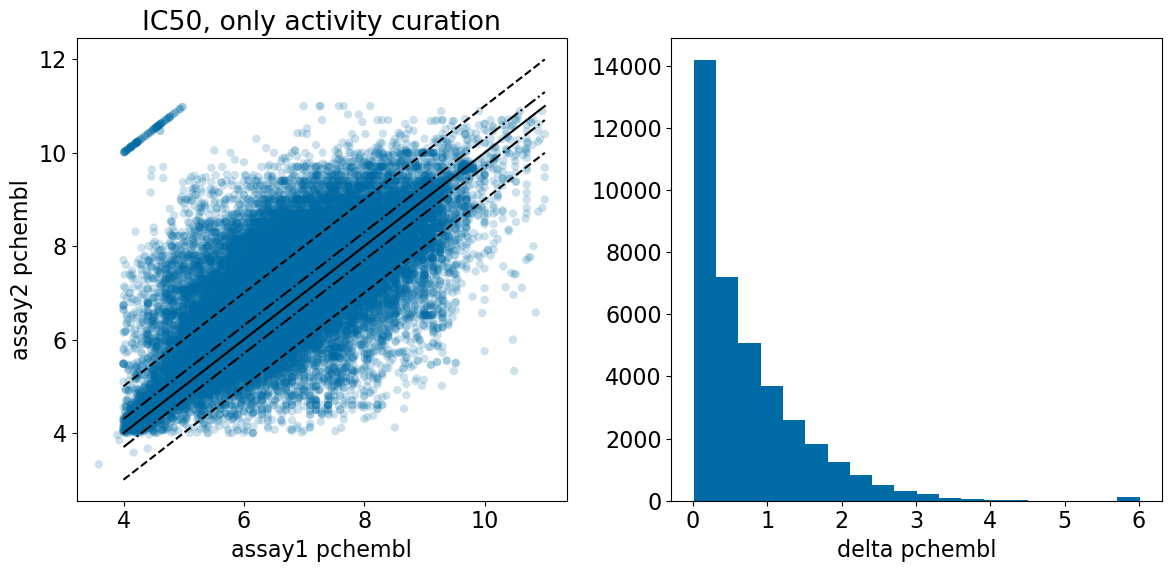

In [5]:
show_comparison_paper(pts[tag],'IC50, only activity curation')
plt.savefig(f'{figdir}/IC50_minimal_curation.pdf',bbox_inches='tight')

In [4]:
tag = 'IC50, larger assays, only activity curation'
pts[tag] = gather_data('IC50',noDuplicateDocs=False,removeMutants=False,maxAssaySize=1000,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=True,
                       onlyDocs=False, onlyHighConfidence=False)

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 1599 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:

1599 assay pairs.
R2=0.32, Spearman R=0.68, Kendall Tau=0.51, MAE=0.51
50385 points. Fraction > 0.3: 0.65, fraction > 1.0: 0.28
Fraction with different classifications:
	 bin=5: 0.07, kappa=0.50, balanced=0.72, mcc=0.51
	 [[44703, 1199], [2373, 2110]]
	 bin=6: 0.16, kappa=0.56, balanced=0.76, mcc=0.56
	 [[33122, 2767], [5811, 8685]]
	 bin=7: 0.24, kappa=0.51, balanced=0.76, mcc=0.52
	 [[18649, 3642], [8781, 19313]]
	 bin=8: 0.19, kappa=0.48, balanced=0.78, mcc=0.49
	 [[7063, 2682], [6905, 33735]]
	 bin=9: 0.05, kappa=0.51, balanced=0.78, mcc=0.51
	 [[1539, 1011], [1644, 46191]]


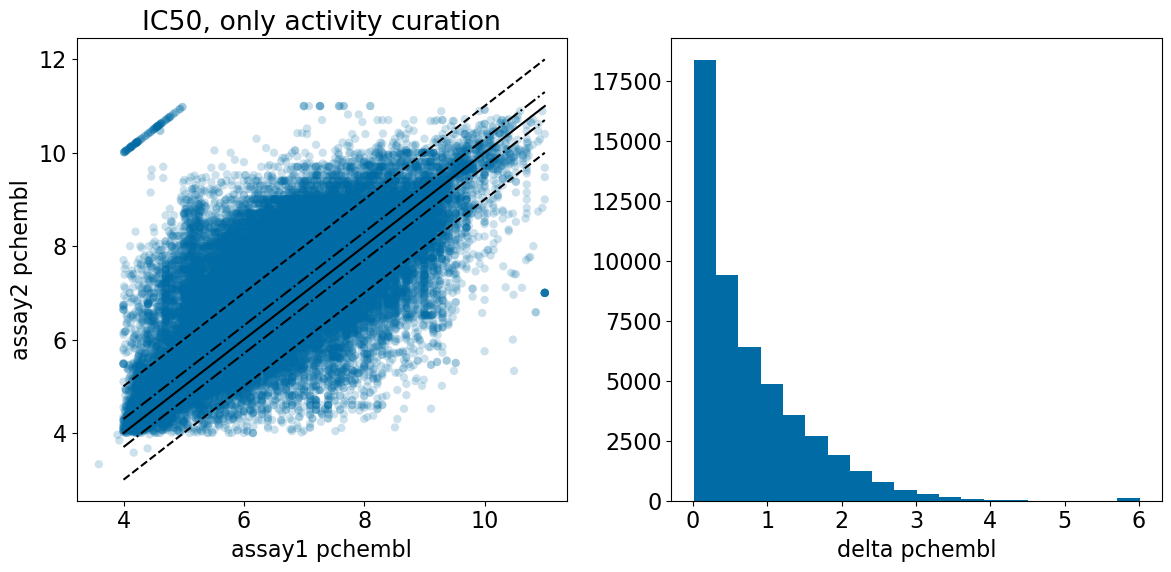

In [5]:
show_comparison_paper(pts[tag],'IC50, only activity curation')
plt.savefig(f'{figdir}/IC50_minimal_curation.large.pdf',bbox_inches='tight')

## Max curation

In [8]:
tag = 'IC50, max curation'
pts[tag] = gather_data('IC50')

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 26 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://

26 assay pairs.
R2=0.63, Spearman R=0.88, Kendall Tau=0.71, MAE=0.27
340 points. Fraction > 0.3: 0.48, fraction > 1.0: 0.13
Fraction with different classifications:
	 bin=5: 0.02, kappa=0.72, balanced=0.86, mcc=0.72
	 [[321, 4], [4, 11]]
	 bin=6: 0.07, kappa=0.80, balanced=0.91, mcc=0.80
	 [[256, 14], [9, 61]]
	 bin=7: 0.06, kappa=0.86, balanced=0.93, mcc=0.86
	 [[147, 13], [10, 170]]
	 bin=8: 0.16, kappa=0.37, balanced=0.67, mcc=0.37
	 [[30, 38], [26, 246]]
	 bin=9: 0.06, kappa=0.36, balanced=0.74, mcc=0.37
	 [[7, 6], [16, 311]]


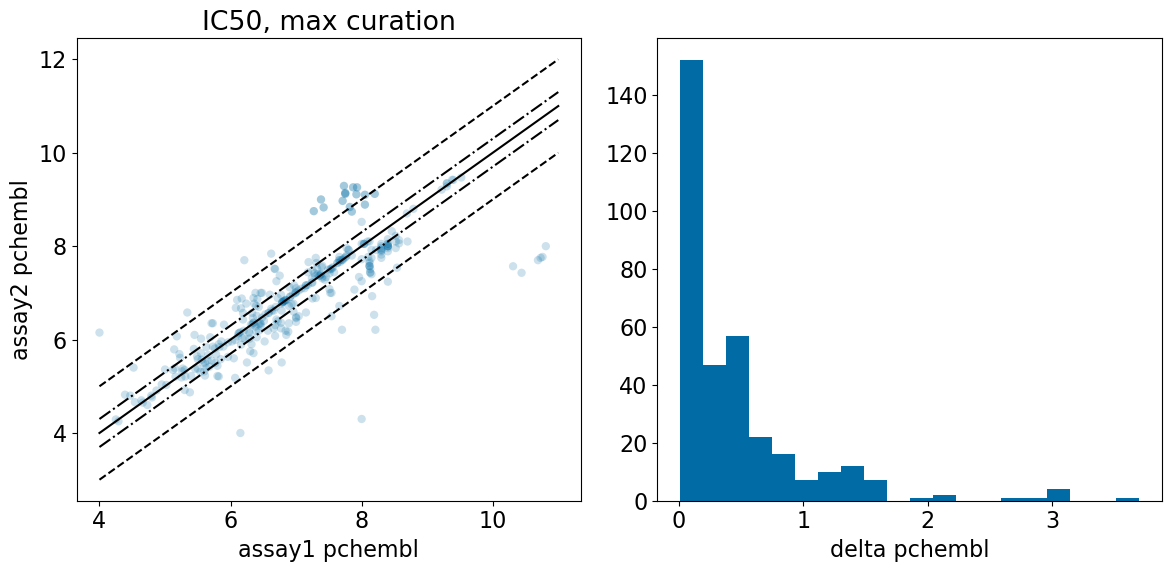

In [9]:
show_comparison_paper(pts[tag],'IC50, max curation')
plt.savefig(f'{figdir}/IC50_max_curation.pdf',bbox_inches='tight')

In [6]:
tag = 'IC50, large assays, max curation'
pts[tag] = gather_data('IC50',maxAssaySize=1000)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 44 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://

44 assay pairs.
R2=0.60, Spearman R=0.77, Kendall Tau=0.61, MAE=0.30
742 points. Fraction > 0.3: 0.51, fraction > 1.0: 0.15
Fraction with different classifications:
	 bin=5: 0.02, kappa=0.73, balanced=0.85, mcc=0.73
	 [[708, 6], [8, 20]]
	 bin=6: 0.04, kappa=0.84, balanced=0.93, mcc=0.84
	 [[619, 17], [12, 94]]
	 bin=7: 0.09, kappa=0.78, balanced=0.89, mcc=0.78
	 [[414, 36], [41, 251]]
	 bin=8: 0.21, kappa=0.46, balanced=0.73, mcc=0.46
	 [[137, 92], [76, 437]]
	 bin=9: 0.03, kappa=0.45, balanced=0.78, mcc=0.46
	 [[10, 7], [16, 709]]


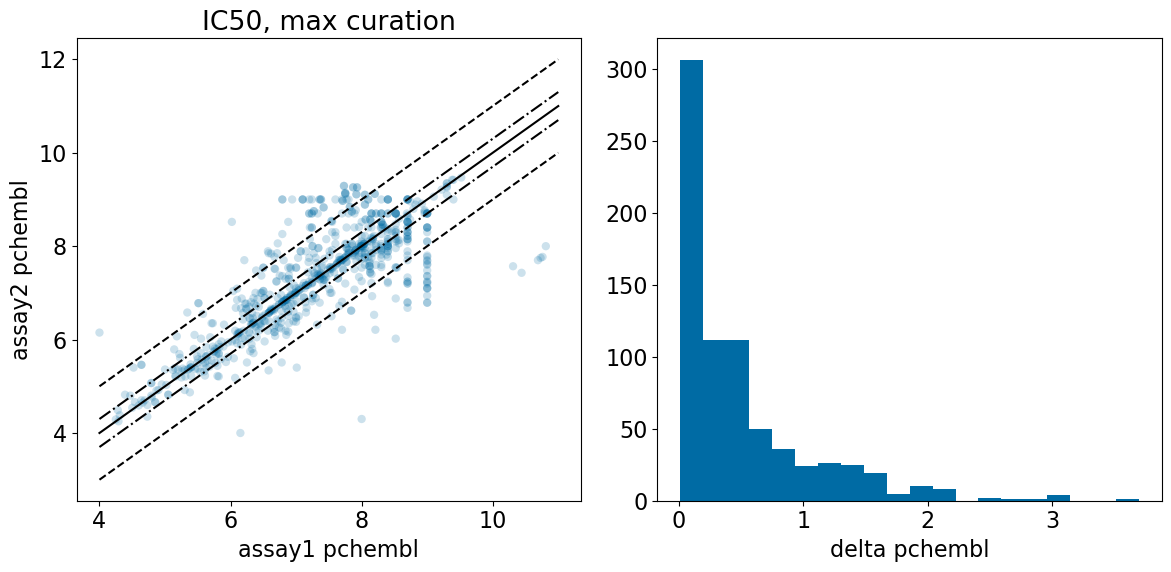

In [7]:
show_comparison_paper(pts[tag],'IC50, max curation')
plt.savefig(f'{figdir}/IC50_max_curation.large.pdf',bbox_inches='tight')

# Ki

## Min curation

In [12]:
tag = 'Ki, LO assays, only activity curation'
pts[tag] = gather_data('Ki',noDuplicateDocs=False,removeMutants=False,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=True,
                       onlyDocs=False, onlyHighConfidence=False)

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 587 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

587 assay pairs.
R2=0.13, Spearman R=0.58, Kendall Tau=0.43, MAE=0.52
7734 points. Fraction > 0.3: 0.67, fraction > 1.0: 0.30
Fraction with different classifications:
	 bin=5: 0.09, kappa=0.40, balanced=0.70, mcc=0.40
	 [[6690, 360], [377, 307]]
	 bin=6: 0.15, kappa=0.47, balanced=0.74, mcc=0.47
	 [[5800, 609], [575, 750]]
	 bin=7: 0.28, kappa=0.42, balanced=0.71, mcc=0.42
	 [[3027, 1112], [1130, 2465]]
	 bin=8: 0.21, kappa=0.41, balanced=0.72, mcc=0.41
	 [[983, 685], [965, 5101]]
	 bin=9: 0.09, kappa=0.25, balanced=0.64, mcc=0.25
	 [[143, 283], [400, 6908]]


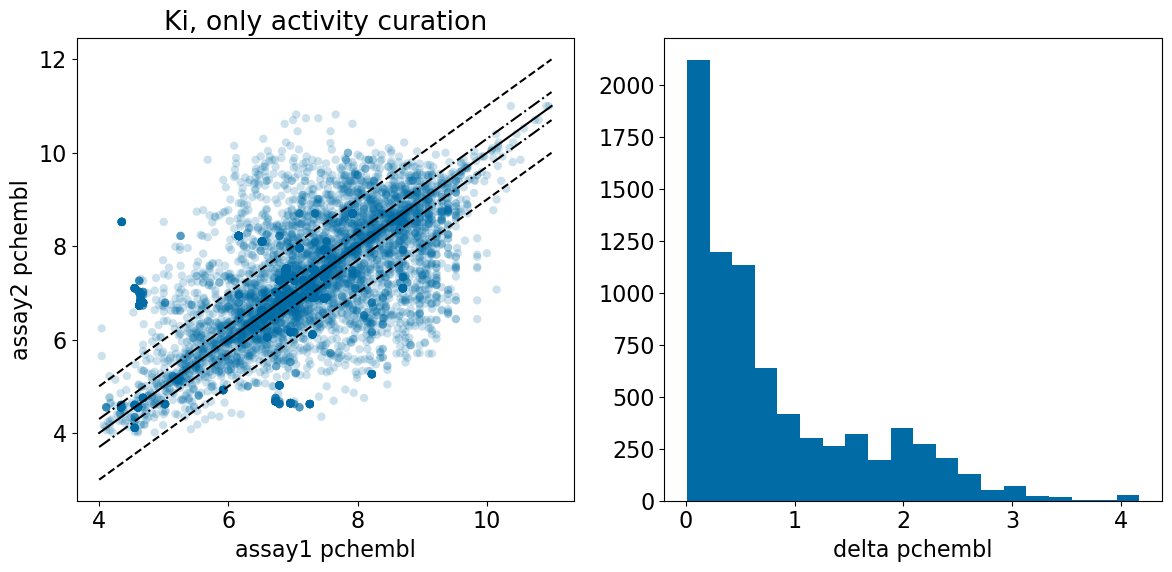

In [13]:
show_comparison_paper(pts[tag],'Ki, only activity curation')
plt.savefig(f'{figdir}/Ki_minimal_curation.pdf',bbox_inches='tight')

In [4]:
tag = 'Ki, larger assays, only activity curation'
pts[tag] = gather_data('Ki',noDuplicateDocs=False,removeMutants=False,maxAssaySize=1000,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=True,
                       onlyDocs=False, onlyHighConfidence=False)

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 750 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32


750 assay pairs.
R2=0.21, Spearman R=0.62, Kendall Tau=0.46, MAE=0.46
9650 points. Fraction > 0.3: 0.64, fraction > 1.0: 0.27
Fraction with different classifications:
	 bin=5: 0.09, kappa=0.48, balanced=0.74, mcc=0.48
	 [[8324, 436], [413, 477]]
	 bin=6: 0.13, kappa=0.52, balanced=0.76, mcc=0.52
	 [[7312, 693], [639, 1006]]
	 bin=7: 0.26, kappa=0.46, balanced=0.73, mcc=0.46
	 [[3994, 1298], [1270, 3088]]
	 bin=8: 0.21, kappa=0.43, balanced=0.73, mcc=0.43
	 [[1339, 812], [1227, 6272]]
	 bin=9: 0.08, kappa=0.33, balanced=0.69, mcc=0.34
	 [[232, 319], [450, 8649]]


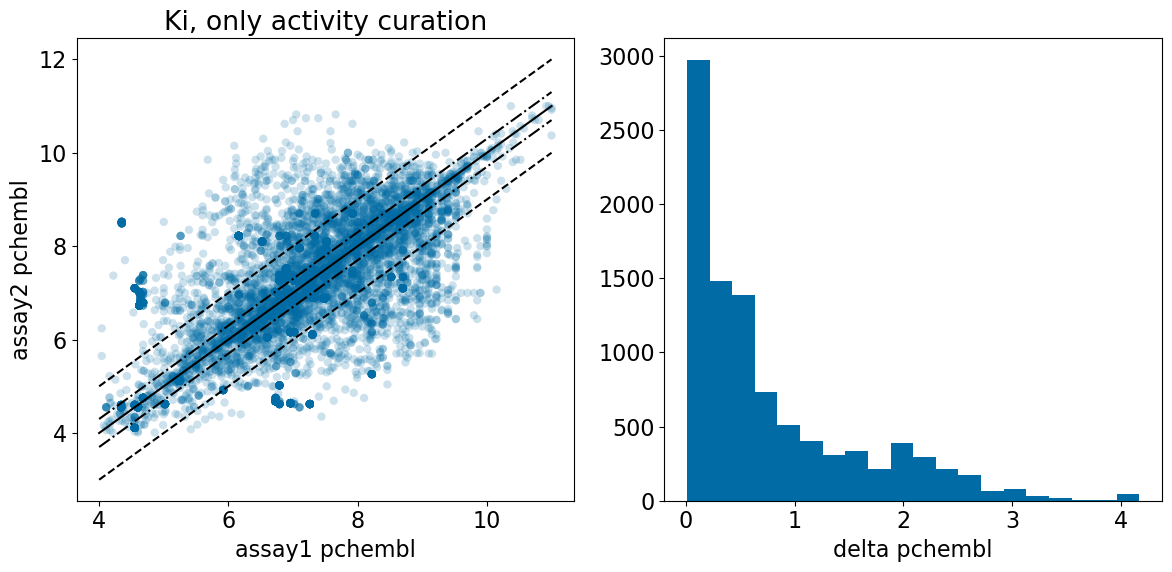

In [5]:
show_comparison_paper(pts[tag],'Ki, only activity curation')
plt.savefig(f'{figdir}/Ki_minimal_curation.large.pdf',bbox_inches='tight')

## Max curation

In [10]:
tag = 'Ki, max curation'
pts[tag] = gather_data('Ki')

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 282 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

282 assay pairs.
R2=-0.33, Spearman R=0.41, Kendall Tau=0.27, MAE=0.47
2434 points. Fraction > 0.3: 0.69, fraction > 1.0: 0.32
Fraction with different classifications:
	 bin=5: 0.21, kappa=0.15, balanced=0.57, mcc=0.15
	 [[1830, 239], [269, 96]]
	 bin=6: 0.22, kappa=0.27, balanced=0.63, mcc=0.27
	 [[1704, 267], [277, 186]]
	 bin=7: 0.40, kappa=0.20, balanced=0.60, mcc=0.20
	 [[682, 406], [570, 776]]
	 bin=8: 0.16, kappa=0.01, balanced=0.51, mcc=0.01
	 [[19, 120], [285, 2010]]
	 bin=9: 0.00, kappa=0.93, balanced=1.00, mcc=0.94
	 [[7, 0], [1, 2426]]


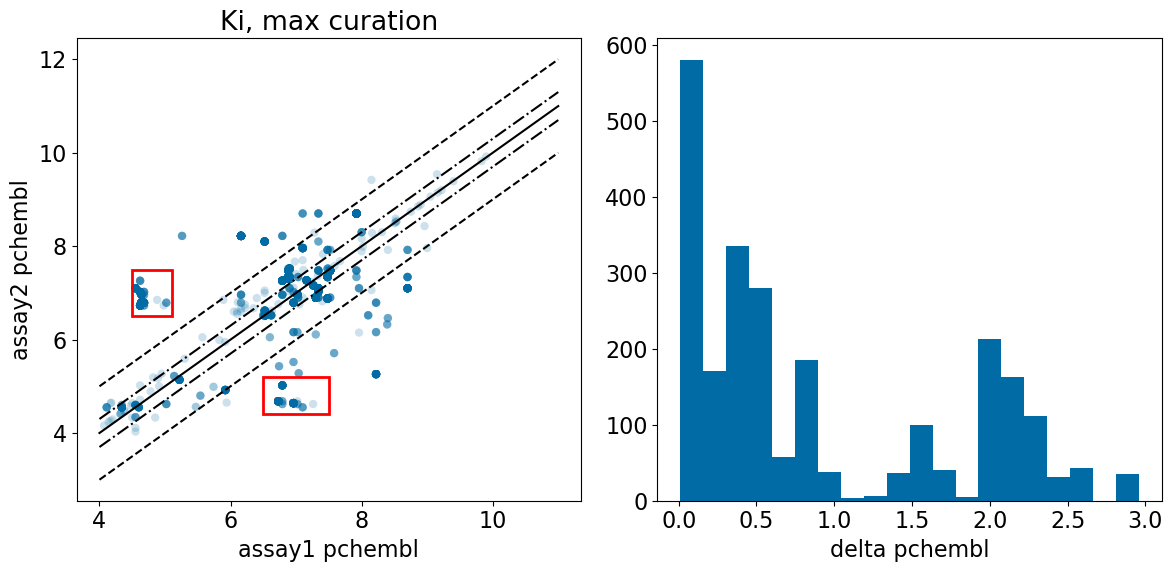

In [11]:
from matplotlib.patches import Rectangle
show_comparison_paper(pts[tag],'Ki, max curation',
                      boxes = [((4.5,6.5),0.6,1.0),((6.5,4.4),1.0,0.8)] )
plt.savefig(f'{figdir}/Ki_max_curation.pdf',bbox_inches='tight')

In [6]:
tag = 'Ki, large assays, max curation'
pts[tag] = gather_data('Ki',maxAssaySize=1000)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 290 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

750 assay pairs.
R2=0.21, Spearman R=0.62, Kendall Tau=0.46, MAE=0.46
9650 points. Fraction > 0.3: 0.64, fraction > 1.0: 0.27
Fraction with different classifications:
	 bin=5: 0.09, kappa=0.48, balanced=0.74, mcc=0.48
	 [[8324, 436], [413, 477]]
	 bin=6: 0.13, kappa=0.52, balanced=0.76, mcc=0.52
	 [[7312, 693], [639, 1006]]
	 bin=7: 0.26, kappa=0.46, balanced=0.73, mcc=0.46
	 [[3994, 1298], [1270, 3088]]
	 bin=8: 0.21, kappa=0.43, balanced=0.73, mcc=0.43
	 [[1339, 812], [1227, 6272]]
	 bin=9: 0.08, kappa=0.33, balanced=0.69, mcc=0.34
	 [[232, 319], [450, 8649]]


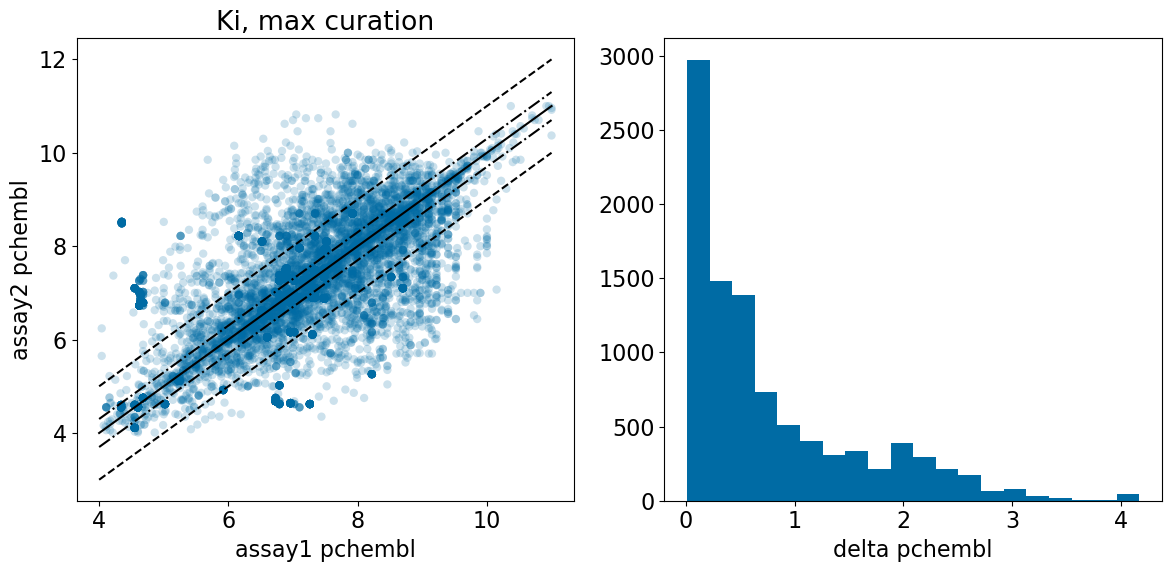

In [76]:
show_comparison_paper(pts[tag],'Ki, max curation')
plt.savefig(f'{figdir}/Ki_max_curation.large.pdf',bbox_inches='tight')

## An anecdote

Tracking down the outliers in the "left corner"

In [20]:
rows = [row for row in pts['Ki, max curation'] if (row[1]<5 and row[2]>6.2 and row[2]<8) or \
                                                   (row[1]>6.2 and row[1]<8 and row[2]<5)]
rows[:5]

[[1519041, Decimal('4.55'), Decimal('7.10'), 1552240, 938521],
 [942, Decimal('6.73'), Decimal('4.68'), 1552240, 938521],
 [932, Decimal('4.68'), Decimal('6.79'), 1552240, 938521],
 [931, Decimal('4.64'), Decimal('6.96'), 1552240, 938521],
 [930, Decimal('4.62'), Decimal('7.02'), 1552240, 938521]]

In [21]:
aids = set()
for row in rows:
    aids.add(row[-2])
    aids.add(row[-1])
len(aids)

32

In [22]:
%sql select assay_id,chembl_id,description from assays where assay_id in (1685271,1465408)

 * postgresql://ccg_read@scotland/chembl_32


[(1465408, 'CHEMBL3407116', 'Inhibition of human recombinant carbonic anhydrase 1 by stopped flow CO2 hydrase assay'),
 (1685271, 'CHEMBL4035750', 'Inhibition of human carbonic anhydrase-1 assessed as reduction in CO2 hydration preincubated for 15 mins followed by CO2 addition measured for 10 to 100 secs by stopped-flow assay')]

Looking at the papers, this looks like a good example of different assay conditions

- https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL3407116/ https://www.sciencedirect.com/science/article/pii/S0968089615001492?via%3Dihub#b0085
- https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL4035750/ https://www.sciencedirect.com/science/article/pii/S0968089617306119?via%3Dihub#b0290

Table 2 in both papers, it looks like the compounds (at least the first 10 or so) have the same numbering. There are compounds which have exactly the same values in both and compounds which are very different. 

In any case, the citations they give for the two assays are different.

Curiously the later paper (the second one) doesn't cite the earlier one, even though the author lists are VERY much the same.


In [23]:
%sql select assay_id,chembl_id,description from assays where assay_id in (1552240,938521)

 * postgresql://ccg_read@scotland/chembl_32


[(938521, 'CHEMBL2327205', 'Inhibition of human recombinant carbonic anhydrase 1 by stopped flow CO2 hydration assay'),
 (1552240, 'CHEMBL3761242', 'Inhibition of human Carbonic anhydrase1 using CO2 as substrate preincubated for 15 mins by stopped-flow CO2 hydration assay')]

Same group as above, same curious lack of self citations even though the similarities are extreme.

In [24]:
len(aids),1552240 in aids

(32, True)

In [18]:
res = %sql select * from (select acts1.assay_id,acts1.chembl_id,tgts.chembl_id target_chembl_id,count(distinct(molregno)) from \
   (select assay_id,chembl_id,tid,molregno from assays \
                                                   join activities using (assay_id)) acts1\
   join (select molregno from activities where assay_id=1563412) acts2 using (molregno) \
   join target_dictionary tgts using (tid) \
   group by (acts1.assay_id,acts1.chembl_id,tgts.chembl_id)) tmp where count>10 order by count desc;
res

 * postgresql://ccg_read@scotland/chembl_32


[(1282544, 'CHEMBL3101211', 'CHEMBL612545', 40),
 (991722, 'CHEMBL2445070', 'CHEMBL612545', 40),
 (938522, 'CHEMBL2327206', 'CHEMBL205', 40),
 (938798, 'CHEMBL2327942', 'CHEMBL612545', 40),
 (1465411, 'CHEMBL3407119', 'CHEMBL612545', 40),
 (1465410, 'CHEMBL3407118', 'CHEMBL612545', 40),
 (1465409, 'CHEMBL3407117', 'CHEMBL205', 40),
 (1465408, 'CHEMBL3407116', 'CHEMBL261', 40),
 (1456836, 'CHEMBL3367569', 'CHEMBL612545', 40),
 (1456835, 'CHEMBL3367568', 'CHEMBL612545', 40),
 (1456834, 'CHEMBL3367567', 'CHEMBL612545', 40),
 (1456833, 'CHEMBL3367566', 'CHEMBL205', 40),
 (1456832, 'CHEMBL3367565', 'CHEMBL261', 40),
 (1349994, 'CHEMBL3270420', 'CHEMBL612545', 40),
 (1349993, 'CHEMBL3270419', 'CHEMBL612545', 40),
 (1349992, 'CHEMBL3270418', 'CHEMBL612545', 40),
 (1349990, 'CHEMBL3270416', 'CHEMBL205', 40),
 (1349989, 'CHEMBL3270415', 'CHEMBL261', 40),
 (1282848, 'CHEMBL3102349', 'CHEMBL612545', 40),
 (1282847, 'CHEMBL3102348', 'CHEMBL612545', 40),
 (1282546, 'CHEMBL3101213', 'CHEMBL205', 40),
 (1282545, 'CHEMBL3101212', 'CHEMBL612545', 40),
 (1282543, 'CHEMBL3101210', 'CHEMBL3097982', 40),
 (1567382, 'CHEMBL3789760', 'CHEMBL612545', 40),
 (1563415, 'CHEMBL3782912', 'CHEMBL612545', 40),
 (1563414, 'CHEMBL3782911', 'CHEMBL612545', 40),
 (1563413, 'CHEMBL3782910', 'CHEMBL205', 40),
 (1563412, 'CHEMBL3782909', 'CHEMBL261', 40),
 (1553898, 'CHEMBL3767552', 'CHEMBL612545', 40),
 (1553897, 'CHEMBL3767551', 'CHEMBL612545', 40),
 (1553896, 'CHEMBL3767550', 'CHEMBL612545', 40),
 (1553895, 'CHEMBL3767549', 'CHEMBL612545', 40),
 (1553894, 'CHEMBL3767548', 'CHEMBL205', 40),
 (1552240, 'CHEMBL3761242', 'CHEMBL261', 40),
 (1552239, 'CHEMBL3761241', 'CHEMBL205', 40),
 (1552238, 'CHEMBL3761240', 'CHEMBL612545', 40),
 (1552127, 'CHEMBL3760464', 'CHEMBL612545', 40),
 (938521, 'CHEMBL2327205', 'CHEMBL261', 40),
 (1466707, 'CHEMBL3404500', 'CHEMBL3399914', 40),
 (1466706, 'CHEMBL3404499', 'CHEMBL205', 40),
 (1466705, 'CHEMBL3404498', 'CHEMBL261', 40),
 (1465412, 'CHEMBL3407120', 'CHEMBL612545', 40),
 (1685272, 'CHEMBL4035751', 'CHEMBL205', 39),
 (1685271, 'CHEMBL4035750', 'CHEMBL261', 39),
 (1685270, 'CHEMBL4035749', 'CHEMBL612545', 39),
 (1685269, 'CHEMBL4035748', 'CHEMBL612545', 39),
 (1925023, 'CHEMBL4427979', 'CHEMBL205', 39),
 (1925022, 'CHEMBL4427978', 'CHEMBL261', 39),
 (1511555, 'CHEMBL3607055', 'CHEMBL205', 39),
 (1511554, 'CHEMBL3607054', 'CHEMBL612545', 39),
 (1511553, 'CHEMBL3607053', 'CHEMBL612545', 39),
 (1511552, 'CHEMBL3607052', 'CHEMBL612545', 39),
 (1475817, 'CHEMBL3425083', 'CHEMBL612545', 39),
 (1461814, 'CHEMBL3395808', 'CHEMBL612545', 39),
 (1925024, 'CHEMBL4427980', 'CHEMBL612545', 39),
 (1461812, 'CHEMBL3395806', 'CHEMBL261', 38),
 (1461813, 'CHEMBL3395807', 'CHEMBL205', 38),
 (1652373, 'CHEMBL4001628', 'CHEMBL612545', 37),
 (1652372, 'CHEMBL4001627', 'CHEMBL612545', 37),
 (1652371, 'CHEMBL4001626', 'CHEMBL205', 37),
 (1652370, 'CHEMBL4001625', 'CHEMBL261', 37),
 (1543854, 'CHEMBL3749744', 'CHEMBL3621035', 34),
 (1543853, 'CHEMBL3749743', 'CHEMBL3745586', 34),
 (1543852, 'CHEMBL3748431', 'CHEMBL205', 34),
 (1543851, 'CHEMBL3748430', 'CHEMBL261', 34),
 (878955, 'CHEMBL2185518', 'CHEMBL612545', 34),
 (700656, 'CHEMBL1645695', 'CHEMBL205', 33),
 (700655, 'CHEMBL1645694', 'CHEMBL261', 33),
 (515851, 'CHEMBL993110', 'CHEMBL5931', 33),
 (562984, 'CHEMBL1015321', 'CHEMBL261', 33),
 (562985, 'CHEMBL1015322', 'CHEMBL205', 33),
 (562990, 'CHEMBL1015327', 'CHEMBL612545', 33),
 (578466, 'CHEMBL1063125', 'CHEMBL5337', 33),
 (578467, 'CHEMBL1063126', 'CHEMBL612545', 33),
 (578468, 'CHEMBL1063127', 'CHEMBL205', 33),
 (578469, 'CHEMBL1063128', 'CHEMBL261', 33),
 (587741, 'CHEMBL1038577', 'CHEMBL261', 33),
 (587742, 'CHEMBL1038578', 'CHEMBL205', 33),
 (587743, 'CHEMBL1038579', 'CHEMBL1075028', 33),
 (588927, 'CHEMBL1063842', 'CHEMBL205', 33),
 (588928, 'CHEMBL1063843', 'CHEMBL6068', 33),
 (801827, 'CHEMBL1947439', 'CHEMBL1944499', 33),
 (762743, 'CHEMBL1815994', 'CHEMBL612545', 33),
 (762742, 'CHEMBL1815993', 'CHEMBL612545', 33),
 (762737, 'CHEMB

In [19]:
len(res)

239

In [21]:
aaids = [x[0] for x in res]
chembl_aaids = [x[1] for x in res]



In [ ]:
pts['Ki, max curation pruned'] = [row for row in pts['Ki, max curation'] if row[-1] not in aaids and row[-2] not in aaids]

show_comparison_paper(pts['Ki, max curation pruned'],'Ki, max curation, pruned')


9 assay pairs.
R2=0.65, Spearman R=0.82, Kendall Tau=0.67, MAE=0.45
115 points. Fraction > 0.3: 0.58, fraction > 1.0: 0.25
Fraction with different classifications:
	 bin=5: 0.13, kappa=0.64, balanced=0.83, mcc=0.64
	 [[80, 9], [6, 20]]
	 bin=6: 0.15, kappa=0.69, balanced=0.86, mcc=0.69
	 [[63, 12], [5, 35]]
	 bin=7: 0.19, kappa=0.59, balanced=0.79, mcc=0.61
	 [[35, 19], [4, 57]]
	 bin=8: 0.11, kappa=0.66, balanced=0.79, mcc=0.68
	 [[19, 12], [2, 82]]
	 bin=9: 0.01, kappa=0.93, balanced=1.00, mcc=0.93
	 [[7, 0], [1, 107]]


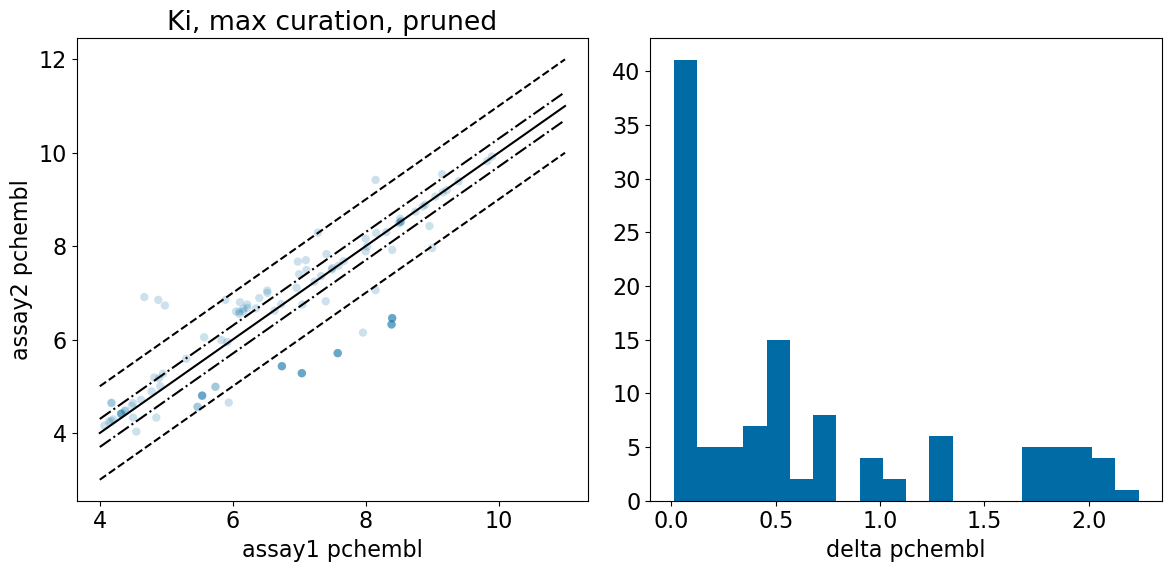

In [28]:
pts['Ki, large assays, max curation pruned'] = [row for row in pts['Ki, large assays, max curation'] if row[-1] not in aaids and row[-2] not in aaids]

show_comparison_paper(pts['Ki, max curation pruned'],'Ki, max curation, pruned')


## End of anecdote

# Pruning Ki data

We're going to remove any assay which has at least 10 compounds in common with 1563412 (CHEMBL3782909).

In [48]:
res = %sql select * from (select acts1.assay_id,acts1.chembl_id,tgts.chembl_id target_chembl_id,count(distinct(molregno)) from \
   (select assay_id,chembl_id,tid,molregno from assays \
                                                   join activities using (assay_id)) acts1\
   join (select molregno from activities where assay_id=1563412) acts2 using (molregno) \
   join target_dictionary tgts using (tid) \
   group by (acts1.assay_id,acts1.chembl_id,tgts.chembl_id)) tmp where count>10 order by count desc;
res

aaids = [x[0] for x in res]
chembl_aaids = [x[1] for x in res]

 * postgresql://ccg_read@scotland/chembl_32


In [49]:
repr(aaids)

'[1282544, 991722, 938522, 938798, 1465411, 1465410, 1465409, 1465408, 1456836, 1456835, 1456834, 1456833, 1456832, 1349994, 1349993, 1349992, 1349990, 1349989, 1282848, 1282847, 1282546, 1282545, 1282543, 1567382, 1563415, 1563414, 1563413, 1563412, 1553898, 1553897, 1553896, 1553895, 1553894, 1552240, 1552239, 1552238, 1552127, 938521, 1466707, 1466706, 1466705, 1465412, 1685272, 1685271, 1685270, 1685269, 1925023, 1925022, 1511555, 1511554, 1511553, 1511552, 1475817, 1461814, 1925024, 1461812, 1461813, 1652373, 1652372, 1652371, 1652370, 1543854, 1543853, 1543852, 1543851, 878955, 700656, 700655, 515851, 562984, 562985, 562990, 578466, 578467, 578468, 578469, 587741, 587742, 587743, 588927, 588928, 801827, 762743, 762742, 762737, 762736, 700659, 700658, 700657, 497634, 497635, 497636, 497637, 515849, 515850, 801828, 801829, 826239, 826238, 517304, 449604, 955917, 517300, 517301, 517302, 826242, 517303, 826240, 726067, 610754, 726066, 726070, 726071, 956001, 956002, 956003, 956004, 3

In [50]:
repr(chembl_aaids)

"['CHEMBL3101211', 'CHEMBL2445070', 'CHEMBL2327206', 'CHEMBL2327942', 'CHEMBL3407119', 'CHEMBL3407118', 'CHEMBL3407117', 'CHEMBL3407116', 'CHEMBL3367569', 'CHEMBL3367568', 'CHEMBL3367567', 'CHEMBL3367566', 'CHEMBL3367565', 'CHEMBL3270420', 'CHEMBL3270419', 'CHEMBL3270418', 'CHEMBL3270416', 'CHEMBL3270415', 'CHEMBL3102349', 'CHEMBL3102348', 'CHEMBL3101213', 'CHEMBL3101212', 'CHEMBL3101210', 'CHEMBL3789760', 'CHEMBL3782912', 'CHEMBL3782911', 'CHEMBL3782910', 'CHEMBL3782909', 'CHEMBL3767552', 'CHEMBL3767551', 'CHEMBL3767550', 'CHEMBL3767549', 'CHEMBL3767548', 'CHEMBL3761242', 'CHEMBL3761241', 'CHEMBL3761240', 'CHEMBL3760464', 'CHEMBL2327205', 'CHEMBL3404500', 'CHEMBL3404499', 'CHEMBL3404498', 'CHEMBL3407120', 'CHEMBL4035751', 'CHEMBL4035750', 'CHEMBL4035749', 'CHEMBL4035748', 'CHEMBL4427979', 'CHEMBL4427978', 'CHEMBL3607055', 'CHEMBL3607054', 'CHEMBL3607053', 'CHEMBL3607052', 'CHEMBL3425083', 'CHEMBL3395808', 'CHEMBL4427980', 'CHEMBL3395806', 'CHEMBL3395807', 'CHEMBL4001628', 'CHEMBL40016

## Max curation

9 assay pairs.
R2=0.65, Spearman R=0.82, Kendall Tau=0.67, MAE=0.45
115 points. Fraction > 0.3: 0.58, fraction > 1.0: 0.25
Fraction with different classifications:
	 bin=5: 0.13, kappa=0.64, balanced=0.83, mcc=0.64
	 [[80, 9], [6, 20]]
	 bin=6: 0.15, kappa=0.69, balanced=0.86, mcc=0.69
	 [[63, 12], [5, 35]]
	 bin=7: 0.19, kappa=0.59, balanced=0.79, mcc=0.61
	 [[35, 19], [4, 57]]
	 bin=8: 0.11, kappa=0.66, balanced=0.79, mcc=0.68
	 [[19, 12], [2, 82]]
	 bin=9: 0.01, kappa=0.93, balanced=1.00, mcc=0.93
	 [[7, 0], [1, 107]]


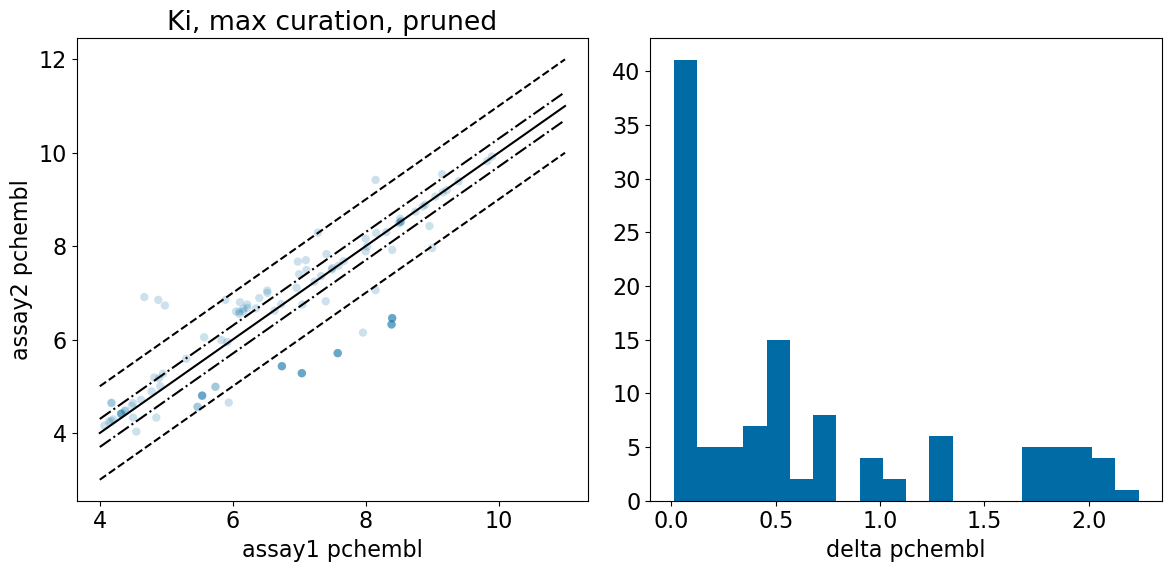

In [12]:
pts['Ki, max curation pruned'] = [row for row in pts['Ki, max curation'] if row[-1] not in aaids and row[-2] not in aaids]

show_comparison_paper(pts['Ki, max curation pruned'],'Ki, max curation, pruned')

plt.savefig(f'{figdir}/Ki_max_curation.pruned.pdf',bbox_inches='tight')

17 assay pairs.
R2=0.68, Spearman R=0.84, Kendall Tau=0.71, MAE=0.12
255 points. Fraction > 0.3: 0.38, fraction > 1.0: 0.21
Fraction with different classifications:
	 bin=5: 0.07, kappa=0.66, balanced=0.84, mcc=0.66
	 [[218, 9], [8, 20]]
	 bin=6: 0.09, kappa=0.73, balanced=0.87, mcc=0.73
	 [[192, 12], [10, 41]]
	 bin=7: 0.14, kappa=0.64, balanced=0.83, mcc=0.64
	 [[137, 27], [16, 75]]
	 bin=8: 0.11, kappa=0.73, balanced=0.86, mcc=0.73
	 [[104, 25], [10, 116]]
	 bin=9: 0.09, kappa=0.75, balanced=0.86, mcc=0.75
	 [[58, 16], [10, 171]]


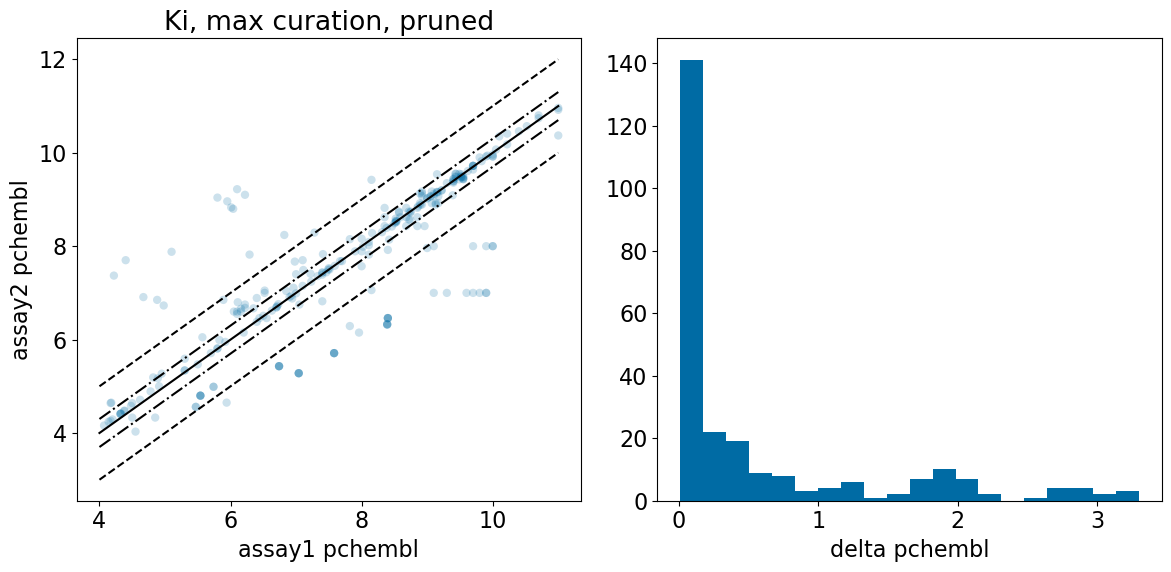

In [74]:
tag = 'Ki, large assays, max curation'
ptag = tag + ', pruned'

pts[ptag] = [row for row in pts[tag] if row[-1] not in aaids and row[-2] not in aaids]

show_comparison_paper(pts[ptag],'Ki, max curation, pruned')

plt.savefig(f'{figdir}/Ki_max_curation.large.pruned.pdf',bbox_inches='tight')

## Min curation


587 assay pairs.
R2=0.13, Spearman R=0.58, Kendall Tau=0.43, MAE=0.52
7734 points. Fraction > 0.3: 0.67, fraction > 1.0: 0.30
Fraction with different classifications:
	 bin=5: 0.09, kappa=0.40, balanced=0.70, mcc=0.40
	 [[6690, 360], [377, 307]]
	 bin=6: 0.15, kappa=0.47, balanced=0.74, mcc=0.47
	 [[5800, 609], [575, 750]]
	 bin=7: 0.28, kappa=0.42, balanced=0.71, mcc=0.42
	 [[3027, 1112], [1130, 2465]]
	 bin=8: 0.21, kappa=0.41, balanced=0.72, mcc=0.41
	 [[983, 685], [965, 5101]]
	 bin=9: 0.09, kappa=0.25, balanced=0.64, mcc=0.25
	 [[143, 283], [400, 6908]]


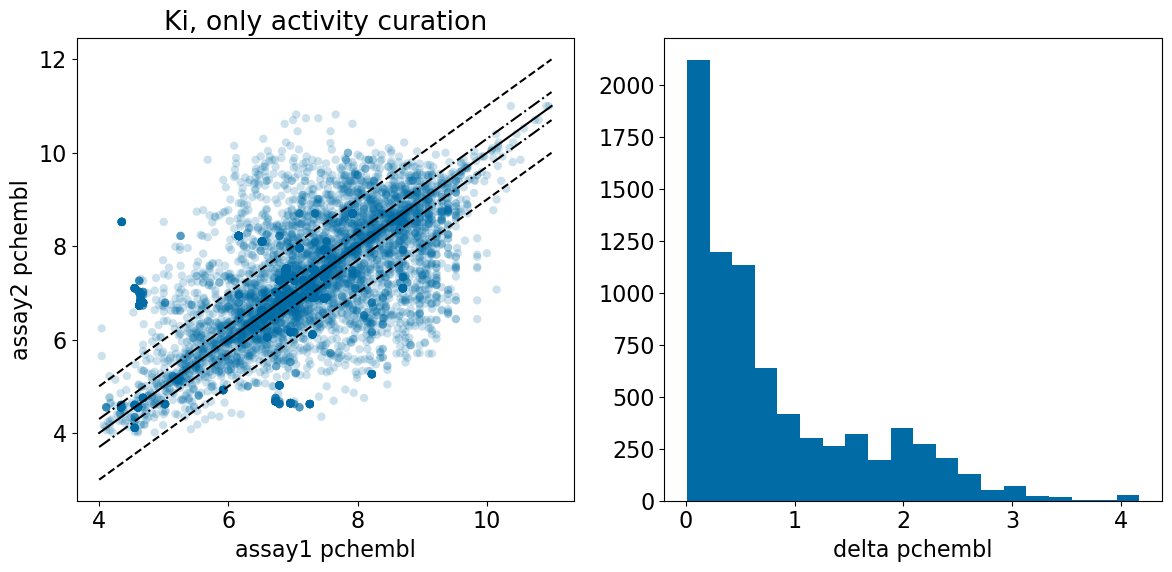

In [32]:
tag = 'Ki, LO assays, only activity curation'
show_comparison_paper(pts[tag],'Ki, only activity curation')


267 assay pairs.
R2=0.27, Spearman R=0.63, Kendall Tau=0.47, MAE=0.50
5750 points. Fraction > 0.3: 0.65, fraction > 1.0: 0.27
Fraction with different classifications:
	 bin=5: 0.02, kappa=0.60, balanced=0.81, mcc=0.60
	 [[5510, 74], [61, 105]]
	 bin=6: 0.10, kappa=0.56, balanced=0.79, mcc=0.56
	 [[4657, 333], [273, 487]]
	 bin=7: 0.20, kappa=0.55, balanced=0.78, mcc=0.55
	 [[3001, 683], [534, 1532]]
	 bin=8: 0.25, kappa=0.45, balanced=0.73, mcc=0.45
	 [[1333, 671], [786, 2960]]
	 bin=9: 0.13, kappa=0.30, balanced=0.67, mcc=0.31
	 [[232, 319], [448, 4751]]


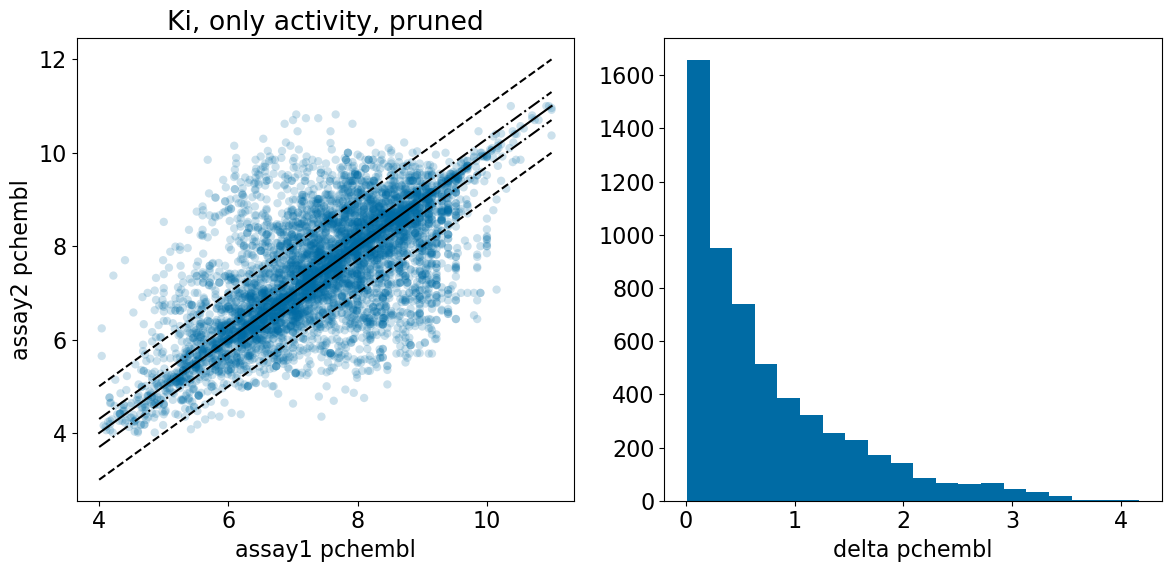

In [17]:
ptag = tag + ', pruned'

pts[ptag] = [row for row in pts[tag] if row[-1] not in aaids and row[-2] not in aaids]

show_comparison_paper(pts[ptag],'Ki, only activity, pruned')

plt.savefig(f'{figdir}/Ki_minimal_curation.pruned.pdf',bbox_inches='tight')

267 assay pairs.
R2=0.27, Spearman R=0.63, Kendall Tau=0.47, MAE=0.50
5750 points. Fraction > 0.3: 0.65, fraction > 1.0: 0.27
Fraction with different classifications:
	 bin=5: 0.02, kappa=0.60, balanced=0.81, mcc=0.60
	 [[5510, 74], [61, 105]]
	 bin=6: 0.10, kappa=0.56, balanced=0.79, mcc=0.56
	 [[4657, 333], [273, 487]]
	 bin=7: 0.20, kappa=0.55, balanced=0.78, mcc=0.55
	 [[3001, 683], [534, 1532]]
	 bin=8: 0.25, kappa=0.45, balanced=0.73, mcc=0.45
	 [[1333, 671], [786, 2960]]
	 bin=9: 0.13, kappa=0.30, balanced=0.67, mcc=0.31
	 [[232, 319], [448, 4751]]


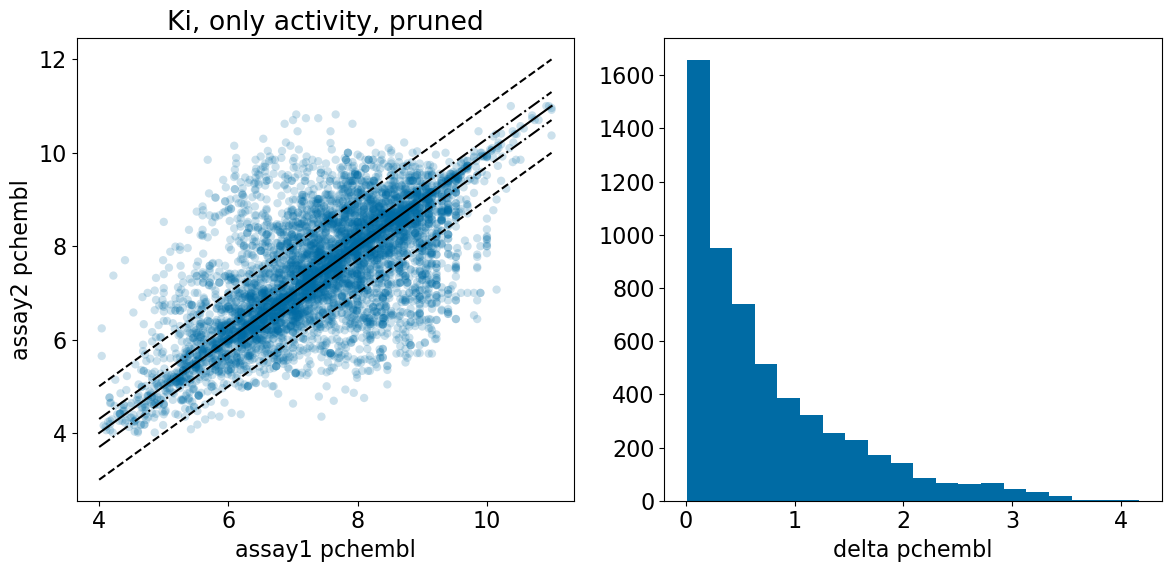

In [75]:
tag = 'Ki, larger assays, only activity curation'
ptag = tag + ', pruned'

pts[ptag] = [row for row in pts[tag] if row[-1] not in aaids and row[-2] not in aaids]

show_comparison_paper(pts[ptag],'Ki, only activity, pruned')

plt.savefig(f'{figdir}/Ki_minimal_curation.large.pruned.pdf',bbox_inches='tight')

# Impact of the individual curation steps

In [15]:
tmp_pts = gather_data('IC50',noDuplicateDocs=False,removeMutants=False,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=False,
                       onlyDocs=False, onlyHighConfidence=False)
print(f'num assay pairs: {len(set((x[-2],x[-1]) for x in tmp_pts))}, num compound pairs: {len(tmp_pts)}')

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 1776 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

In [17]:
tmp_pts = gather_data('IC50',noDuplicateDocs=False,removeMutants=False,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=True,
                       onlyDocs=False, onlyHighConfidence=False)
print(f'num assay pairs: {len(set((x[-2],x[-1]) for x in tmp_pts))}, num compound pairs: {len(tmp_pts)}')

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 1358 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

In [23]:
tmp_pts = gather_data('IC50',noDuplicateDocs=True,removeMutants=False,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=False,
                       onlyDocs=False, onlyHighConfidence=False)
print(f'num assay pairs: {len(set((x[-2],x[-1]) for x in tmp_pts))}, num compound pairs: {len(tmp_pts)}')

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 642 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

In [24]:
tmp_pts = gather_data('IC50',noDuplicateDocs=False,removeMutants=True,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=False,
                       onlyDocs=False, onlyHighConfidence=False)
print(f'num assay pairs: {len(set((x[-2],x[-1]) for x in tmp_pts))}, num compound pairs: {len(tmp_pts)}')

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 1582 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

In [19]:
tmp_pts = gather_data('IC50',noDuplicateDocs=False,removeMutants=False,
                       maxMatch=False,includeAssayType=True,includeActivityCuration=False,
                       onlyDocs=False, onlyHighConfidence=False)
print(f'num assay pairs: {len(set((x[-2],x[-1]) for x in tmp_pts))}, num compound pairs: {len(tmp_pts)}')

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 1583 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

In [20]:
tmp_pts = gather_data('IC50',noDuplicateDocs=False,removeMutants=False,
                       maxMatch=True,includeAssayType=False,includeActivityCuration=False,
                       onlyDocs=False, onlyHighConfidence=False)
print(f'num assay pairs: {len(set((x[-2],x[-1]) for x in tmp_pts))}, num compound pairs: {len(tmp_pts)}')

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 698 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:/

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

In [21]:
tmp_pts = gather_data('IC50',noDuplicateDocs=False,removeMutants=False,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=False,
                       onlyDocs=True, onlyHighConfidence=False)
print(f'num assay pairs: {len(set((x[-2],x[-1]) for x in tmp_pts))}, num compound pairs: {len(tmp_pts)}')

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 1593 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

In [22]:
tmp_pts = gather_data('IC50',noDuplicateDocs=False,removeMutants=False,
                       maxMatch=False,includeAssayType=False,includeActivityCuration=False,
                       onlyDocs=False, onlyHighConfidence=False,maxAssaySize=100000)
print(f'num assay pairs: {len(set((x[-2],x[-1]) for x in tmp_pts))}, num compound pairs: {len(tmp_pts)}')

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl2
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks_ovl3
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
get assays
 * postgresql://ccg_read@scotland/chembl_32
retrieving data for 2172 assay pairs
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql:

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

# Count large assays in ChEMBL32

In [3]:
%config SqlMagic.feedback = False
connection_string = f"postgresql://ccg_read@scotland/chembl_32"

%sql $connection_string \
    drop table if exists temp_ic50_assays
%sql $connection_string \
    drop table if exists temp_ki_assays


%sql \
select assay_id,assays.chembl_id assay_chembl_id,description,tid,targets.chembl_id target_chembl_id,\
          pref_name,assays.doc_id doc_id,count(distinct(molregno)) cnt \
        into temporary table temp_ic50_assays  \
        from activities  \
        join assays using(assay_id)  \
        join target_dictionary as targets using (tid) \
        where pchembl_value is not null   \
        and standard_type='IC50' \
        and standard_units = 'nM'  \
        and data_validity_comment is null  \
        and standard_relation = '=' \
        and target_type = 'SINGLE PROTEIN' \
        group by (assay_id,assays.chembl_id,description,tid,targets.chembl_id,pref_name,\
                  assays.doc_id) \
        order by cnt desc; 

%sql \
select assay_id,assays.chembl_id assay_chembl_id,description,tid,targets.chembl_id target_chembl_id,\
          pref_name,assays.doc_id doc_id,count(distinct(molregno)) cnt \
        into temporary table temp_ki_assays  \
        from activities  \
        join assays using(assay_id)  \
        join target_dictionary as targets using (tid) \
        where pchembl_value is not null   \
        and standard_type='Ki' \
        and standard_units = 'nM'  \
        and data_validity_comment is null  \
        and standard_relation = '=' \
        and target_type = 'SINGLE PROTEIN' \
        group by (assay_id,assays.chembl_id,description,tid,targets.chembl_id,pref_name,\
                  assays.doc_id) \
        order by cnt desc; 


d_ic50s = %sql select * from temp_ic50_assays where cnt>100;
d_kis = %sql select * from temp_ki_assays where cnt>100;

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32


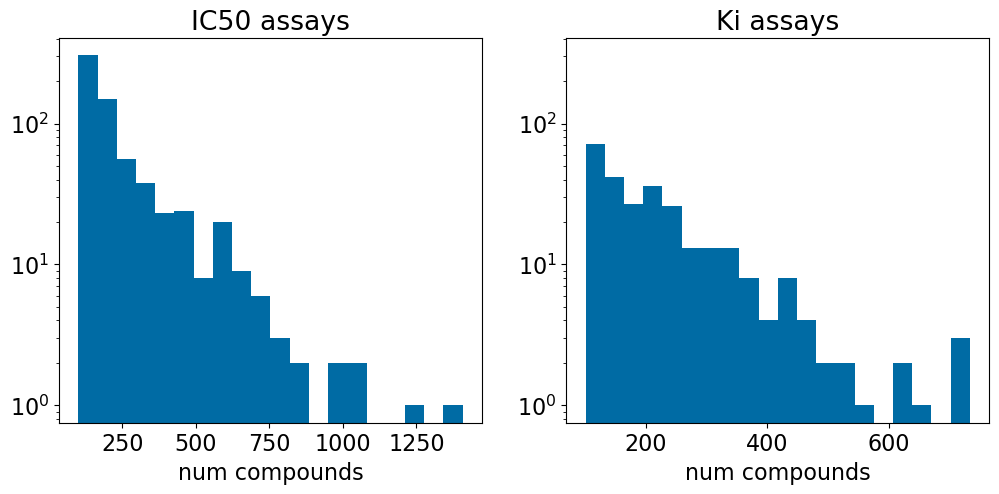

In [4]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist([x[-1] for x in d_ic50s],bins=20,log=True)
plt.title('IC50 assays')
plt.xlabel('num compounds')
yl = plt.ylim()

plt.subplot(1,2,2)
plt.hist([x[-1] for x in d_kis],bins=20,log=True)
plt.title('Ki assays')
plt.xlabel('num compounds');
plt.ylim(*yl)
plt.savefig(f'{figdir}/chembl32_assay_counts.pdf',bbox_inches='tight')

# Impact of curation on dataset sizes

In [5]:
# password is stored in ~/.pgpass, so we don't need to worry about it here
connection_string = f"postgresql://ccg_read@scotland/chembl_32"

def gather_data_for_size(standard_type,
                minAssaySize=20,maxAssaySize=100,
                onlyDocs=True,removeMutants=False,noDuplicateDocs=False,
                onlyHighConfidence=True):

    %config SqlMagic.feedback = False

    %sql $connection_string \
        drop table if exists temp_assays

    if standard_type in ('Ki','IC50'):
        %sql \
        select assay_id,assays.chembl_id assay_chembl_id,description,tid,targets.chembl_id target_chembl_id,\
                  count(distinct(molregno)) cnt,pref_name,assays.doc_id doc_id,docs.year doc_date,variant_id \
                into temporary table temp_assays  \
                from activities  \
                join assays using(assay_id)  \
                join docs on (assays.doc_id = docs.doc_id)  \
                join target_dictionary as targets using (tid) \
                where pchembl_value is not null   \
                and standard_type=:standard_type \
                and standard_units = 'nM'  \
                and data_validity_comment is null  \
                and standard_relation = '=' \
                and target_type = 'SINGLE PROTEIN' \
                group by (assay_id,assays.chembl_id,description,tid,targets.chembl_id,pref_name,\
                          assays.doc_id,docs.year,variant_id) \
                order by cnt desc; 
    else:
        raise NotImplementedError('Only Ki and IC50 are currently supported')
                  
    if onlyDocs:
        %sql \
        delete from temp_assays where doc_date is null;

    if removeMutants:
        %sql \
        delete from temp_assays where variant_id is null and lower(description) like '%mutant%' or lower(description) like '%variant%' \
           or lower(description) like '%mutation%';       

    if onlyHighConfidence:
        %sql \
          alter table temp_assays rename to temp_assays_1;
        %sql \
          select ta1.* into temporary table temp_assays \
            from temp_assays_1 ta1 join assays using(assay_id) \
            where confidence_score = 9;
        %sql \
           drop table temp_assays_1;

        
    print('goldilocks')
    %sql \
        drop table if exists goldilocks
    %sql \
    select assay_id,tid,molregno,standard_type into temporary table goldilocks \
    from activities \
    join temp_assays using (assay_id) \
    where pchembl_value is not null   \
    and standard_units = 'nM'  \
    and data_validity_comment is null  \
    and standard_relation = '=' \
    and cnt<=:maxAssaySize;

    # remove readouts that we're not interested in
    if standard_type in ('Ki','IC50'):
        %sql \
        delete from goldilocks where standard_type != :standard_type;

    # count the number of unique compounds in each assay id
    print('goldilocks counts')
    %sql \
        drop table if exists tmp_counts
    %sql \
    select assay_id,g.tid,count(distinct molregno) cnt,doc_id into temporary table tmp_counts \
    from goldilocks g join assays using (assay_id) \
    group by (assay_id,g.tid,doc_id) \
    order by cnt desc;
    
    %sql \
        drop table if exists goldilocks_counts

    if noDuplicateDocs:
        # the "distinct on" here ensures that we only get one assay per target per doc
        #   we get the first one, which is the largest since tmp_counts is ordered by cnt
        %sql \
        select distinct on (tid,doc_id) \
          assay_id,tid,doc_id,cnt into temporary table goldilocks_counts \
        from tmp_counts where cnt>=:minAssaySize and cnt<=:maxAssaySize;
    else:
        %sql \
        select distinct on (tid,assay_id) \
          assay_id,tid,doc_id,cnt into temporary table goldilocks_counts \
        from tmp_counts where cnt>=:minAssaySize and cnt<=:maxAssaySize;
        
    %sql \
        drop table if exists goldilocks_target_counts

    %sql \
      select tid,count(distinct assay_id) target_assay_count,sum(cnt) target_compound_count \
        into temporary table goldilocks_target_counts \
        from goldilocks_counts gc \
        group by (tid);
        
        


 

In [8]:
data_counts = {}

In [9]:
readout = 'IC50'
tag = f'{readout}, LO assays'
gather_data_for_size(readout,onlyHighConfidence=False,onlyDocs=False)
data_counts[readout] = %sql select * from goldilocks_target_counts order by target_compound_count desc;

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks counts
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32


In [10]:
d = %sql \
  select assay_id,assay_chembl_id,temp_assays.tid,target_chembl_id,standard_type,pchembl_value, \
    md5(textin(record_out((assay_type,assay_organism,assay_category,assay_tax_id,\
              assay_strain,assay_tissue,assay_cell_type,assay_subcellular_fraction,bao_format,temp_assays.variant_id)))) assay_conditions_hash, \
    molregno, cid.chembl_id compound_chembl_id,canonical_smiles \
    from activities \
    join temp_assays using (assay_id) \
    join goldilocks_target_counts using (tid) \
    join goldilocks_counts using (assay_id) \
    join assays using (assay_id) \
    join chembl_id_lookup cid on (entity_type='COMPOUND' and molregno=entity_id) \
    join compound_structures using (molregno) \
    where target_assay_count >=20 and target_compound_count >=1000 \
                and pchembl_value is not null   \
                and standard_type=:readout \
                and standard_units = 'nM'  \
                and data_validity_comment is null  \
                and standard_relation = '=' \
    ;
#    where tid = :tid;
ic50_store = d
len(d)

 * postgresql://ccg_read@scotland/chembl_32


147088

In [11]:
readout = 'IC50'
tag = f'{readout}, LO assays'
gather_data_for_size(readout,onlyDocs=True,removeMutants=True,noDuplicateDocs=True,
                onlyHighConfidence=True)
data_counts[readout+"_high"] = %sql select * from goldilocks_target_counts order by target_compound_count desc;

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks counts
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32


In [12]:
d = %sql \
  select assay_id,assay_chembl_id,temp_assays.tid,target_chembl_id,standard_type,pchembl_value, \
    md5(textin(record_out((assay_type,assay_organism,assay_category,assay_tax_id,\
              assay_strain,assay_tissue,assay_cell_type,assay_subcellular_fraction,bao_format,temp_assays.variant_id)))) assay_conditions_hash, \
    molregno, cid.chembl_id compound_chembl_id,canonical_smiles \
    from activities \
    join temp_assays using (assay_id) \
    join goldilocks_target_counts using (tid) \
    join goldilocks_counts using (assay_id) \
    join assays using (assay_id) \
    join chembl_id_lookup cid on (entity_type='COMPOUND' and molregno=entity_id) \
    join compound_structures using (molregno) \
    where target_assay_count >=20 and target_compound_count >=1000 \
                and pchembl_value is not null   \
                and standard_type=:readout \
                and standard_units = 'nM'  \
                and data_validity_comment is null  \
                and standard_relation = '=' \
    ;
#    where tid = :tid;
maxcuration_ic50_store = d
len(d)

 * postgresql://ccg_read@scotland/chembl_32


64985

In [13]:
readout = 'Ki'
tag = f'{readout}, LO assays'
gather_data_for_size(readout,onlyHighConfidence=False,onlyDocs=False)
data_counts[readout] = %sql select * from goldilocks_target_counts order by target_compound_count desc;

 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks counts
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32


In [14]:
d = %sql \
  select assay_id,assay_chembl_id,temp_assays.tid,target_chembl_id,standard_type,pchembl_value, \
    md5(textin(record_out((assay_type,assay_organism,assay_category,assay_tax_id,\
              assay_strain,assay_tissue,assay_cell_type,assay_subcellular_fraction,bao_format,temp_assays.variant_id)))) assay_conditions_hash, \
    molregno, cid.chembl_id compound_chembl_id,canonical_smiles \
    from activities \
    join temp_assays using (assay_id) \
    join goldilocks_target_counts using (tid) \
    join goldilocks_counts using (assay_id) \
    join assays using (assay_id) \
    join chembl_id_lookup cid on (entity_type='COMPOUND' and molregno=entity_id) \
    join compound_structures using (molregno) \
    where target_assay_count >=20 and target_compound_count >=1000 \
                and pchembl_value is not null   \
                and standard_type=:readout \
                and standard_units = 'nM'  \
                and data_validity_comment is null  \
                and standard_relation = '=' \
    ;
#    where tid = :tid;
#ki_store = [row for row in d if row[1] not in chembl_aaids]
ki_store = d
len(ki_store),len(d)

 * postgresql://ccg_read@scotland/chembl_32


(82313, 82313)

In [15]:
readout = 'Ki'
tag = f'{readout}, LO assays'
gather_data_for_size(readout,onlyDocs=True,removeMutants=True,noDuplicateDocs=True,
                onlyHighConfidence=True)
data_counts[readout+"_high"] = %sql select * from goldilocks_target_counts order by target_compound_count desc;

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks counts
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32


In [16]:
d = %sql \
  select assay_id,assay_chembl_id,temp_assays.tid,target_chembl_id,standard_type,pchembl_value, \
    md5(textin(record_out((assay_type,assay_organism,assay_category,assay_tax_id,\
              assay_strain,assay_tissue,assay_cell_type,assay_subcellular_fraction,bao_format,temp_assays.variant_id)))) assay_conditions_hash, \
    molregno, cid.chembl_id compound_chembl_id,canonical_smiles \
    from activities \
    join temp_assays using (assay_id) \
    join goldilocks_target_counts using (tid) \
    join goldilocks_counts using (assay_id) \
    join assays using (assay_id) \
    join chembl_id_lookup cid on (entity_type='COMPOUND' and molregno=entity_id) \
    join compound_structures using (molregno) \
    where target_assay_count >=20 and target_compound_count >=1000 \
                and pchembl_value is not null   \
                and standard_type=:readout \
                and standard_units = 'nM'  \
                and data_validity_comment is null  \
                and standard_relation = '=' \
    ;
#    where tid = :tid;
maxcuration_ki_store = [row for row in d if row[1]]

len(d)

 * postgresql://ccg_read@scotland/chembl_32


51978

In [24]:
chembl_aaids=['CHEMBL3101211', 'CHEMBL2445070', 'CHEMBL2327206', 'CHEMBL2327942', 'CHEMBL3407119', 'CHEMBL3407118', 'CHEMBL3407117', 'CHEMBL3407116', 'CHEMBL3367569', 'CHEMBL3367568', 'CHEMBL3367567', 'CHEMBL3367566', 'CHEMBL3367565', 'CHEMBL3270420', 'CHEMBL3270419', 'CHEMBL3270418', 'CHEMBL3270416', 'CHEMBL3270415', 'CHEMBL3102349', 'CHEMBL3102348', 'CHEMBL3101213', 'CHEMBL3101212', 'CHEMBL3101210', 'CHEMBL3789760', 'CHEMBL3782912', 'CHEMBL3782911', 'CHEMBL3782910', 'CHEMBL3782909', 'CHEMBL3767552', 'CHEMBL3767551', 'CHEMBL3767550', 'CHEMBL3767549', 'CHEMBL3767548', 'CHEMBL3761242', 'CHEMBL3761241', 'CHEMBL3761240', 'CHEMBL3760464', 'CHEMBL2327205', 'CHEMBL3404500', 'CHEMBL3404499', 'CHEMBL3404498', 'CHEMBL3407120', 'CHEMBL4035751', 'CHEMBL4035750', 'CHEMBL4035749', 'CHEMBL4035748', 'CHEMBL4427979', 'CHEMBL4427978', 'CHEMBL3607055', 'CHEMBL3607054', 'CHEMBL3607053', 'CHEMBL3607052', 'CHEMBL3425083', 'CHEMBL3395808', 'CHEMBL4427980', 'CHEMBL3395806', 'CHEMBL3395807', 'CHEMBL4001628', 'CHEMBL4001627', 'CHEMBL4001626', 'CHEMBL4001625', 'CHEMBL3749744', 'CHEMBL3749743', 'CHEMBL3748431', 'CHEMBL3748430', 'CHEMBL2185518', 'CHEMBL1645695', 'CHEMBL1645694', 'CHEMBL993110', 'CHEMBL1015321', 'CHEMBL1015322', 'CHEMBL1015327', 'CHEMBL1063125', 'CHEMBL1063126', 'CHEMBL1063127', 'CHEMBL1063128', 'CHEMBL1038577', 'CHEMBL1038578', 'CHEMBL1038579', 'CHEMBL1063842', 'CHEMBL1063843', 'CHEMBL1947439', 'CHEMBL1815994', 'CHEMBL1815993', 'CHEMBL1815988', 'CHEMBL1815987', 'CHEMBL1645698', 'CHEMBL1645697', 'CHEMBL1645696', 'CHEMBL1002983', 'CHEMBL1002984', 'CHEMBL1002985', 'CHEMBL1002986', 'CHEMBL993108', 'CHEMBL993109', 'CHEMBL1947440', 'CHEMBL1947441', 'CHEMBL2049250', 'CHEMBL2049249', 'CHEMBL1031357', 'CHEMBL898699', 'CHEMBL2379886', 'CHEMBL1031353', 'CHEMBL1031354', 'CHEMBL1031355', 'CHEMBL2049253', 'CHEMBL1031356', 'CHEMBL2049251', 'CHEMBL1678663', 'CHEMBL1064389', 'CHEMBL1678662', 'CHEMBL1678666', 'CHEMBL1678667', 'CHEMBL2380058', 'CHEMBL2380059', 'CHEMBL2380060', 'CHEMBL2380061', 'CHEMBL865638', 'CHEMBL895192', 'CHEMBL895191', 'CHEMBL862664', 'CHEMBL863824', 'CHEMBL863823', 'CHEMBL861561', 'CHEMBL861560', 'CHEMBL861559', 'CHEMBL864357', 'CHEMBL896308', 'CHEMBL896309', 'CHEMBL911283', 'CHEMBL862670', 'CHEMBL911284', 'CHEMBL911285', 'CHEMBL862669', 'CHEMBL911286', 'CHEMBL862671', 'CHEMBL829846', 'CHEMBL827186', 'CHEMBL829640', 'CHEMBL829822', 'CHEMBL828815', 'CHEMBL658750', 'CHEMBL657039', 'CHEMBL828135', 'CHEMBL657967', 'CHEMBL657825', 'CHEMBL828932', 'CHEMBL830339', 'CHEMBL3789758', 'CHEMBL828071', 'CHEMBL657150', 'CHEMBL3789752', 'CHEMBL3789754', 'CHEMBL3789755', 'CHEMBL828925', 'CHEMBL4513082', 'CHEMBL4495582', 'CHEMBL876689', 'CHEMBL832583', 'CHEMBL838574', 'CHEMBL839013', 'CHEMBL839012', 'CHEMBL658217', 'CHEMBL4651403', 'CHEMBL4731750', 'CHEMBL840160', 'CHEMBL827205', 'CHEMBL827204', 'CHEMBL830313', 'CHEMBL830312', 'CHEMBL876374', 'CHEMBL658042', 'CHEMBL657828', 'CHEMBL657153', 'CHEMBL662724', 'CHEMBL657821', 'CHEMBL1108468', 'CHEMBL657146', 'CHEMBL658749', 'CHEMBL867755', 'CHEMBL870709', 'CHEMBL657028', 'CHEMBL824221', 'CHEMBL3737169', 'CHEMBL873200', 'CHEMBL824219', 'CHEMBL824220', 'CHEMBL657976', 'CHEMBL3737173', 'CHEMBL657848', 'CHEMBL3737172', 'CHEMBL3737170', 'CHEMBL870708', 'CHEMBL657970', 'CHEMBL657149', 'CHEMBL657025', 'CHEMBL4303805', 'CHEMBL827937', 'CHEMBL657824', 'CHEMBL4303810', 'CHEMBL653170', 'CHEMBL658942', 'CHEMBL828069', 'CHEMBL875708', 'CHEMBL839950', 'CHEMBL875538', 'CHEMBL1217310', 'CHEMBL657042', 'CHEMBL1960463', 'CHEMBL1960462', 'CHEMBL1960461', 'CHEMBL659048', 'CHEMBL657145', 'CHEMBL1217308', 'CHEMBL1217309', 'CHEMBL1106525', 'CHEMBL2415808', 'CHEMBL2429043', 'CHEMBL4303819', 'CHEMBL3116664', 'CHEMBL3116665', 'CHEMBL2429044', 'CHEMBL3116666', 'CHEMBL828074', 'CHEMBL2429045', 'CHEMBL2429046', 'CHEMBL2429047', 'CHEMBL3116663', 'CHEMBL2429048', 'CHEMBL3116661', 'CHEMBL657820', 'CHEMBL2415807', 'CHEMBL827065', 'CHEMBL2415806', 'CHEMBL3116662', 'CHEMBL828905', 'CHEMBL828908', 'CHEMBL3562119', 'CHEMBL3561990']

In [33]:
from collections import Counter
nocuration_assay_count_ic50 = Counter()
nocuration_cmpd_count_ic50 = Counter()
maxcuration_assay_count_ic50 = Counter()
maxcuration_cmpd_count_ic50 = Counter()
last_assay = None
for row in ic50_store:
    tid = row[3]
    aid = row[1]
    conds = row[6]
    if aid != last_assay:
        nocuration_assay_count_ic50[tid] += 1
        #maxcuration_assay_count_ic50[tid+conds] += 1
        last_assay = aid
    nocuration_cmpd_count_ic50[tid] += 1
    #maxcuration_cmpd_count_ic50[tid+conds] += 1
last_assay = None
for row in maxcuration_ic50_store:
    tid = row[3]
    aid = row[1]
    conds = row[6]
    if aid != last_assay:
        maxcuration_assay_count_ic50[tid+"|"+conds] += 1
        last_assay = aid
    maxcuration_cmpd_count_ic50[tid+"|"+conds] += 1

    
    
nocuration_assay_count_ki = Counter()
nocuration_cmpd_count_ki = Counter()
maxcuration_assay_count_ki = Counter()
maxcuration_cmpd_count_ki = Counter()
maxcuration_pruned_assay_count_ki = Counter()
maxcuration_pruned_cmpd_count_ki = Counter()
last_assay = None
for row in ki_store:
    tid = row[3]
    aid = row[1]
    conds = row[6]
    if aid != last_assay:
        nocuration_assay_count_ki[tid] += 1
        #maxcuration_assay_count_ic50[tid+conds] += 1
        last_assay = aid
    nocuration_cmpd_count_ki[tid] += 1
    #maxcuration_cmpd_count_ic50[tid+conds] += 1
last_assay = None
for row in maxcuration_ki_store:
    tid = row[3]
    aid = row[1]
    conds = row[6]
    if aid != last_assay:
        maxcuration_assay_count_ki[tid+"|"+conds] += 1
        if aid not in chembl_aaids:
            maxcuration_pruned_assay_count_ki[tid+"|"+conds] += 1
            
        last_assay = aid
    maxcuration_cmpd_count_ki[tid+"|"+conds] += 1
    if aid not in chembl_aaids:
        maxcuration_pruned_cmpd_count_ki[tid+"|"+conds] += 1
    
    

In [34]:
no_curation_scounts = list(sorted(nocuration_cmpd_count_ic50.values(),reverse=True))
max_curation_scounts = list(sorted(maxcuration_cmpd_count_ic50.values(),reverse=True))
ki_no_curation_scounts = list(sorted(nocuration_cmpd_count_ki.values(),reverse=True))
ki_max_curation_scounts = list(sorted(maxcuration_pruned_cmpd_count_ki.values(),reverse=True))
# maxcuration_pruned_cmpd_count_ki

In [41]:
len(nocuration_assay_count_ic50),len(nocuration_assay_count_ki)

(80, 38)

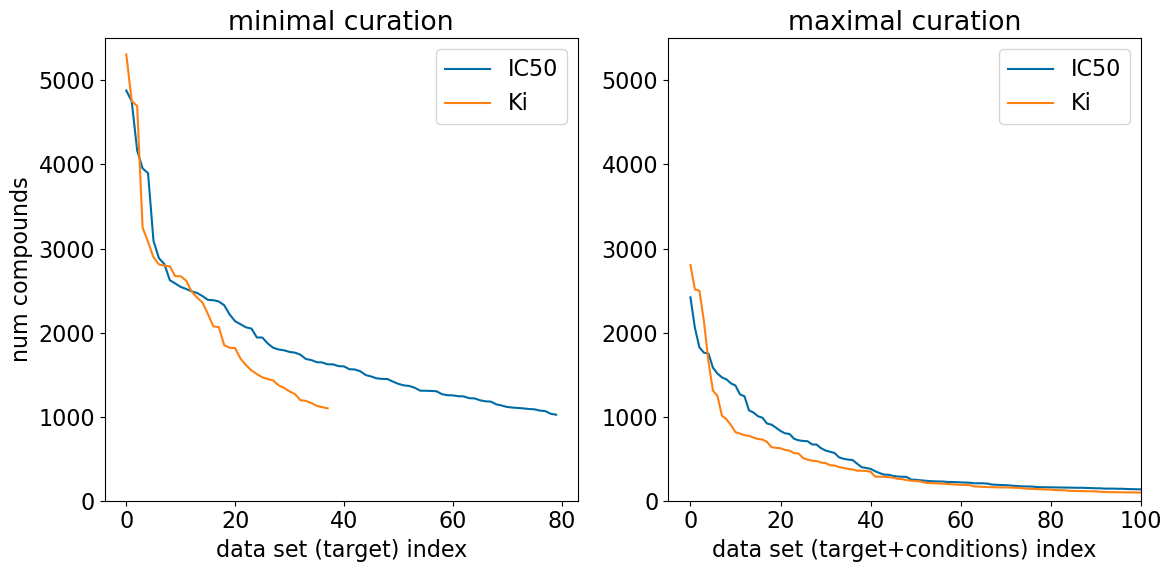

In [39]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

plt.plot(no_curation_scounts,label='IC50')
plt.plot(ki_no_curation_scounts,label='Ki')
plt.legend()
plt.xlabel('data set (target) index');
plt.ylabel('num compounds')
plt.title('minimal curation');
plt.ylim(0,5500)

plt.subplot(1,2,2)
plt.plot(max_curation_scounts,label='IC50')
plt.plot(ki_max_curation_scounts,label='Ki')
plt.legend()
plt.xlabel('data set (target+conditions) index');plt.xlim(-5,100)
#plt.ylabel('num compounds')
plt.title('maximal curation');
plt.ylim(0,5500)
plt.tight_layout()

plt.savefig(f'{figdir}/combined_data_set_sizes.pdf',bbox_inches='tight')

In [28]:
no_curation_scounts = list(sorted(nocuration_cmpd_count_ic50.values(),reverse=True))
max_curation_scounts = list(sorted(maxcuration_cmpd_count_ic50.values(),reverse=True))


In [43]:
no_curation_scounts = list(sorted(nocuration_assay_count_ic50.values(),reverse=True))
max_curation_scounts = list(sorted(maxcuration_assay_count_ic50.values(),reverse=True))
ki_no_curation_scounts = list(sorted(nocuration_assay_count_ki.values(),reverse=True))
ki_max_curation_scounts = list(sorted(maxcuration_pruned_assay_count_ki.values(),reverse=True))
# maxcuration_pruned_cmpd_count_ki

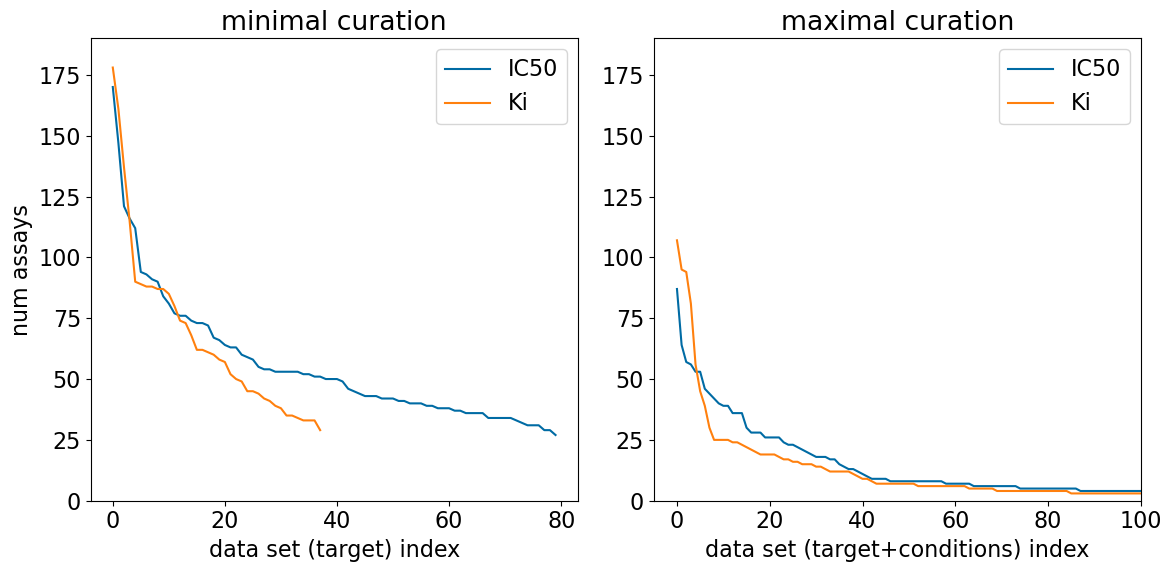

In [47]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

plt.plot(no_curation_scounts,label='IC50')
plt.plot(ki_no_curation_scounts,label='Ki')
plt.legend()
plt.xlabel('data set (target) index');
plt.ylabel('num assays')
plt.title('minimal curation');
plt.ylim(0,190)

plt.subplot(1,2,2)
plt.plot(max_curation_scounts,label='IC50')
plt.plot(ki_max_curation_scounts,label='Ki')
plt.legend()
plt.xlabel('data set (target+conditions) index');
plt.xlim(-5,100)
plt.ylim(0,190)
#plt.ylabel('num compounds')
plt.title('maximal curation');
plt.tight_layout()

plt.savefig(f'{figdir}/combined_assay_data_set_sizes.pdf',bbox_inches='tight')

# Write the data sets

In [12]:
readout = 'IC50'
gather_data_for_size(readout,onlyDocs=True,removeMutants=True,noDuplicateDocs=True,
                onlyHighConfidence=True)


 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks counts
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32


In [13]:
import numpy as np
yaml=[]



raw_data = %sql \
  select assay_id,assay_chembl_id,temp_assays.tid,target_chembl_id,standard_type,pchembl_value, \
    md5(textin(record_out((assay_type,assay_organism,assay_category,assay_tax_id,\
              assay_strain,assay_tissue,assay_cell_type,assay_subcellular_fraction,bao_format,temp_assays.variant_id)))) assay_conditions_hash, \
    molregno, cid.chembl_id compound_chembl_id,canonical_smiles \
    from activities \
    join temp_assays using (assay_id) \
    join goldilocks_target_counts using (tid) \
    join goldilocks_counts using (assay_id) \
    join assays using (assay_id) \
    join chembl_id_lookup cid on (entity_type='COMPOUND' and molregno=entity_id) \
    join compound_structures using (molregno) \
    where target_assay_count >=20 and target_compound_count >=1000 \
                and pchembl_value is not null   \
                and standard_type=:readout \
                and standard_units = 'nM'  \
                and data_validity_comment is null  \
                and standard_relation = '=' \
    ;



 * postgresql://ccg_read@scotland/chembl_32


In [14]:
min_dataset_size = 200 

collected_data = defaultdict(list)
assay_conditions_accum = defaultdict(set)
assay_accum = defaultdict(set)
for (_,assay_chembl_id,_,target_chembl_id,_,pchembl_value, \
       assay_conditions_hash,_,compound_chembl_id,canonical_smiles) in raw_data:
    collected_data[(target_chembl_id,assay_conditions_hash)].append((assay_chembl_id,compound_chembl_id,canonical_smiles,pchembl_value))
    assay_conditions_accum[target_chembl_id].add(assay_conditions_hash)
    assay_accum[(target_chembl_id,assay_conditions_hash)].add(assay_chembl_id)

sets_to_keep = [k for k,v in collected_data.items() if len(v) >= min_dataset_size]

for k in assay_conditions_accum:
    assay_conditions_accum[k] = [y for y in assay_conditions_accum[k] if (k,y) in sets_to_keep]
    


In [15]:
len(collected_data)

356

In [16]:
len(sets_to_keep),len(assay_conditions_accum)

(67, 40)

In [17]:
import pandas as pd
yaml=[]

for target_chembl_id,conds in collected_data.keys():
    if (target_chembl_id,conds) not in sets_to_keep:
        continue
    rows = collected_data[(target_chembl_id,conds)]
    cols = np.array(rows).transpose()
    cond_idx = assay_conditions_accum[target_chembl_id].index(conds) + 1
    
    assays = set([x[0] for x in rows])
    
    
    columns = ['assay_chembl_id','compound_chembl_id','canonical_smiles','pchembl_value']
    df = pd.DataFrame(dict(zip(columns,cols)))
    fname = f'target_{target_chembl_id}-{cond_idx}.{readout}.csv.gz'
    df.to_csv(fname,index=False)
    
    minAct = min(df.pchembl_value)
    maxAct = max(df.pchembl_value)
    medAct = np.median(df.pchembl_value)
    actType = readout
    targetd = %sql \
    select * from target_dictionary  \
        where chembl_id=:target_chembl_id
    targetd = dict(targetd[0])    
    template=f'''  {target_chembl_id}-{cond_idx}:
    description: "Target {target_chembl_id}: {targetd['pref_name']}"
    args:
      filename: '{{{{ CATALOG_DIR }}}}/source_data/{fname}'
      smilesColumn: canonical_smiles
    metadata:
      url: https://www.ebi.ac.uk/chembl/target_report_card/{target_chembl_id}/
      source: ChEMBL_32
      target_organism: {targetd['organism']}
      assays_included: {','.join(assay_accum[(target_chembl_id,conds)])}
      num_points: {len(rows)}
      activity_type: {actType}
      min pchembl_value: {minAct:.2f}
      max pchembl_value: {maxAct:.2f}
      median pchembl_value: {medAct:.2f}
    driver: intake_rdkit.smiles.SmilesSource
'''
    yaml.append(template)
print('\n'.join(yaml))
with open(f'./datasets/{readout}_datasets.yaml','w+') as outf:
    header=f'''metadata:
  version: 1
  creator: 
    name: greg landrum
    email: glandrum@ethz.ch

  summary: |
    Collection of {readout} datasets with pchembl_values for bioactivity prediction.

    Each row includes the reported value. Only values without data_validity_comments are included
    
sources:'''
    print(header,file=outf)
    print('\n'.join(yaml),file=outf)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

In [7]:
readout = 'Ki'
gather_data_for_size(readout,onlyDocs=True,removeMutants=True,noDuplicateDocs=True,
                onlyHighConfidence=True)
import numpy as np
yaml=[]



raw_data = %sql \
  select assay_id,assay_chembl_id,temp_assays.tid,target_chembl_id,standard_type,pchembl_value, \
    md5(textin(record_out((assay_type,assay_organism,assay_category,assay_tax_id,\
              assay_strain,assay_tissue,assay_cell_type,assay_subcellular_fraction,bao_format,temp_assays.variant_id)))) assay_conditions_hash, \
    molregno, cid.chembl_id compound_chembl_id,canonical_smiles \
    from activities \
    join temp_assays using (assay_id) \
    join goldilocks_target_counts using (tid) \
    join goldilocks_counts using (assay_id) \
    join assays using (assay_id) \
    join chembl_id_lookup cid on (entity_type='COMPOUND' and molregno=entity_id) \
    join compound_structures using (molregno) \
    where target_assay_count >=20 and target_compound_count >=1000 \
                and pchembl_value is not null   \
                and standard_type=:readout \
                and standard_units = 'nM'  \
                and data_validity_comment is null  \
                and standard_relation = '=' \
    ;



 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
goldilocks counts
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32


In [8]:
min_dataset_size = 200 

collected_data = defaultdict(list)
assay_conditions_accum = defaultdict(set)
assay_accum = defaultdict(set)
for (_,assay_chembl_id,_,target_chembl_id,_,pchembl_value, \
       assay_conditions_hash,_,compound_chembl_id,canonical_smiles) in raw_data:
    collected_data[(target_chembl_id,assay_conditions_hash)].append((assay_chembl_id,compound_chembl_id,canonical_smiles,pchembl_value))
    assay_conditions_accum[target_chembl_id].add(assay_conditions_hash)
    assay_accum[(target_chembl_id,assay_conditions_hash)].add(assay_chembl_id)

sets_to_keep = [k for k,v in collected_data.items() if len(v) >= min_dataset_size]

for k in assay_conditions_accum:
    assay_conditions_accum[k] = [y for y in assay_conditions_accum[k] if (k,y) in sets_to_keep]
    


In [9]:
len(sets_to_keep),len(assay_conditions_accum)

(57, 26)

In [10]:
sets_to_keep

[('CHEMBL234', 'aab458b586520ad6a82e21e396e745fa'),
 ('CHEMBL224', 'aab458b586520ad6a82e21e396e745fa'),
 ('CHEMBL217', 'aab458b586520ad6a82e21e396e745fa'),
 ('CHEMBL218', '7f73c5dd89b7b6d8ca56c162eee39ae0'),
 ('CHEMBL3155', '9a0ea9c5d064d5578aba12a00c1e51d1'),
 ('CHEMBL224', '9a0ea9c5d064d5578aba12a00c1e51d1'),
 ('CHEMBL3371', '950edee628a799c6d21b79616a3c2922'),
 ('CHEMBL255', '950edee628a799c6d21b79616a3c2922'),
 ('CHEMBL3155', '950edee628a799c6d21b79616a3c2922'),
 ('CHEMBL264', '7f73c5dd89b7b6d8ca56c162eee39ae0'),
 ('CHEMBL226', '9a0ea9c5d064d5578aba12a00c1e51d1'),
 ('CHEMBL244', '7f73c5dd89b7b6d8ca56c162eee39ae0'),
 ('CHEMBL3371', '6a88bba0e3106f72feeac64cca116875'),
 ('CHEMBL217', '9a0ea9c5d064d5578aba12a00c1e51d1'),
 ('CHEMBL259', '950edee628a799c6d21b79616a3c2922'),
 ('CHEMBL253', '7f73c5dd89b7b6d8ca56c162eee39ae0'),
 ('CHEMBL251', 'c6eb716f36a79621c8c73c735dd764f1'),
 ('CHEMBL251', '5b0fe37d404cd3c110d464704646dcec'),
 ('CHEMBL243', '240fe016687488a2b94a2596427b2d46'),
 ('CHEMB

In [11]:
import pandas as pd
yaml=[]

for target_chembl_id,conds in collected_data.keys():
    if (target_chembl_id,conds) not in sets_to_keep:
        continue
    rows = collected_data[(target_chembl_id,conds)]
    cols = np.array(rows).transpose()
    cond_idx = assay_conditions_accum[target_chembl_id].index(conds) + 1
    
    assays = set([x[0] for x in rows])
    
    
    columns = ['assay_chembl_id','compound_chembl_id','canonical_smiles','pchembl_value']
    df = pd.DataFrame(dict(zip(columns,cols)))
    fname = f'target_{target_chembl_id}-{cond_idx}.{readout}.csv.gz'
    df.to_csv(fname,index=False)
    
    minAct = min(df.pchembl_value)
    maxAct = max(df.pchembl_value)
    medAct = np.median(df.pchembl_value)
    actType = readout
    targetd = %sql \
    select * from target_dictionary  \
        where chembl_id=:target_chembl_id
    targetd = dict(targetd[0])    
    template=f'''  {target_chembl_id}-{cond_idx}:
    description: "Target {target_chembl_id}: {targetd['pref_name']}"
    args:
      filename: '{{{{ CATALOG_DIR }}}}/source_data/{fname}'
      smilesColumn: canonical_smiles
    metadata:
      url: https://www.ebi.ac.uk/chembl/target_report_card/{target_chembl_id}/
      source: ChEMBL_32
      target_organism: {targetd['organism']}
      assays_included: {','.join(assay_accum[(target_chembl_id,conds)])}
      num_points: {len(rows)}
      activity_type: {actType}
      min pchembl_value: {minAct:.2f}
      max pchembl_value: {maxAct:.2f}
      median pchembl_value: {medAct:.2f}
    driver: intake_rdkit.smiles.SmilesSource
'''
    yaml.append(template)
print('\n'.join(yaml))
with open(f'./datasets/{readout}_datasets.yaml','w+') as outf:
    header=f'''metadata:
  version: 1
  creator: 
    name: greg landrum
    email: glandrum@ethz.ch

  summary: |
    Collection of {readout} datasets with pchembl_values for bioactivity prediction.

    Each row includes the reported value. Only values without data_validity_comments are included
    
sources:'''
    print(header,file=outf)
    print('\n'.join(yaml),file=outf)

 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotland/chembl_32
 * postgresql://ccg_read@scotlan

Some stats about those

In [51]:
len([1 for x in maxcuration_cmpd_count_ic50.values() if x>=500])

34

In [52]:
len([1 for x in maxcuration_pruned_cmpd_count_ki.values() if x>=500])

26

In [53]:
min([maxcuration_assay_count_ic50[x] for x,y in maxcuration_cmpd_count_ic50.items() if y >=500])

14

In [54]:
min([maxcuration_pruned_assay_count_ki[x] for x,y in maxcuration_pruned_cmpd_count_ki.items() if y >=500])

16